In [ ]:
!curl ipinfo.io

{
  "ip": "34.45.113.175",
  "hostname": "175.113.45.34.bc.googleusercontent.com",
  "city": "Council Bluffs",
  "region": "Iowa",
  "country": "US",
  "loc": "41.2619,-95.8608",
  "org": "AS396982 Google LLC",
  "postal": "51502",
  "timezone": "America/Chicago",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
!pip install yfinance pmdarima statsmodels arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 14.1 MB/s eta 0:00:00


# 1. PACKAGE IMPORTING AND DATA COLLECTION


## 1.1 Import dependencies

In [ ]:
# Standard library imports
import os
import sys
import math
import warnings
import itertools
from math import sqrt
from datetime import datetime
from itertools import product
from datetime import datetime, timedelta

# Third-party library imports
from arch import arch_model
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pmdarima import auto_arima
from pandas.plotting import lag_plot
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# IPython display
from IPython.display import Image, display, HTML

# Matplotlib configuration
# rcParams['figure.figsize'] = 10, 6

In [ ]:
warnings.filterwarnings("ignore")
# Use a consistent style
plt.style.use('seaborn')

## 1.2  Download Data and tickers

In [ ]:
# Download data
TICKER = "TSLA"
target_column = 'Close'

df = yf.download(TICKER, start="2023-01-01", end="2024-01-01").reset_index()

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date just in case it's not in order
df = df.sort_values('Date')

# Calculate the index for 80% of the data
split_point = int(len(df) * 0.8)

# Split the DataFrame into 80% train and 20% test sets
train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000


In [ ]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
200,2023-10-19,225.949997,230.610001,216.779999,220.110001,220.110001,170772700
201,2023-10-20,217.009995,218.860001,210.419998,211.990005,211.990005,137734000
202,2023-10-23,210.000000,216.979996,202.509995,212.080002,212.080002,150683400
203,2023-10-24,216.500000,222.050003,214.110001,216.520004,216.520004,118231100
204,2023-10-25,215.880005,220.100006,212.199997,212.419998,212.419998,107065100


In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000


In [ ]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,250,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,2023-07-02 09:18:43.200000,217.075040,221.631680,212.674320,217.475240,217.475240,1.373222e+08
min,2023-01-03 00:00:00,103.000000,111.750000,101.809998,108.099998,108.099998,6.512520e+07
25%,2023-04-03 06:00:00,186.375004,189.937500,182.912502,186.122494,186.122494,1.117632e+08
50%,2023-07-04 00:00:00,223.564995,226.555000,218.019997,222.144997,222.144997,1.285824e+08
75%,2023-10-01 06:00:00,251.787495,257.992500,247.394993,253.019993,253.019993,1.578840e+08
max,2023-12-29 00:00:00,296.040009,299.290009,289.519989,293.339996,293.339996,3.065906e+08
std,NaN,42.282592,42.458512,41.831715,41.916800,41.916800,3.577310e+07


In [ ]:
# Check for missing values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


## 1.3 Split Data into training and testing sets

In [ ]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
200,2023-10-19,225.949997,230.610001,216.779999,220.110001,220.110001,170772700
201,2023-10-20,217.009995,218.860001,210.419998,211.990005,211.990005,137734000
202,2023-10-23,210.000000,216.979996,202.509995,212.080002,212.080002,150683400
203,2023-10-24,216.500000,222.050003,214.110001,216.520004,216.520004,118231100
204,2023-10-25,215.880005,220.100006,212.199997,212.419998,212.419998,107065100


In [ ]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000


In [ ]:
def plot_open_vs_high(df):
    # df['Date'] = pd.to_datetime(df['Date'])

    plt.figure(figsize=(10, 6))

    # Scatter plot with 'Date' on x-axis and 'High' on y-axis
    plt.scatter(df['Date'], df['Close'], color='blue', edgecolor='black')

    # Set title and labels
    plt.title('Close Price vs Date')
    plt.xlabel('Date')
    plt.ylabel('Close Price')

    # Format the x-axis to show dates clearly
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate date labels for better readability

    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    plt.show()

In [ ]:
# plot_open_vs_high(test)
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
200,2023-10-19,225.949997,230.610001,216.779999,220.110001,220.110001,170772700
201,2023-10-20,217.009995,218.860001,210.419998,211.990005,211.990005,137734000
202,2023-10-23,210.000000,216.979996,202.509995,212.080002,212.080002,150683400
203,2023-10-24,216.500000,222.050003,214.110001,216.520004,216.520004,118231100
204,2023-10-25,215.880005,220.100006,212.199997,212.419998,212.419998,107065100


# 2. Feature Engineering

In [ ]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,250,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,2023-07-02 09:18:43.200000,217.075040,221.631680,212.674320,217.475240,217.475240,1.373222e+08
min,2023-01-03 00:00:00,103.000000,111.750000,101.809998,108.099998,108.099998,6.512520e+07
25%,2023-04-03 06:00:00,186.375004,189.937500,182.912502,186.122494,186.122494,1.117632e+08
50%,2023-07-04 00:00:00,223.564995,226.555000,218.019997,222.144997,222.144997,1.285824e+08
75%,2023-10-01 06:00:00,251.787495,257.992500,247.394993,253.019993,253.019993,1.578840e+08
max,2023-12-29 00:00:00,296.040009,299.290009,289.519989,293.339996,293.339996,3.065906e+08
std,NaN,42.282592,42.458512,41.831715,41.916800,41.916800,3.577310e+07


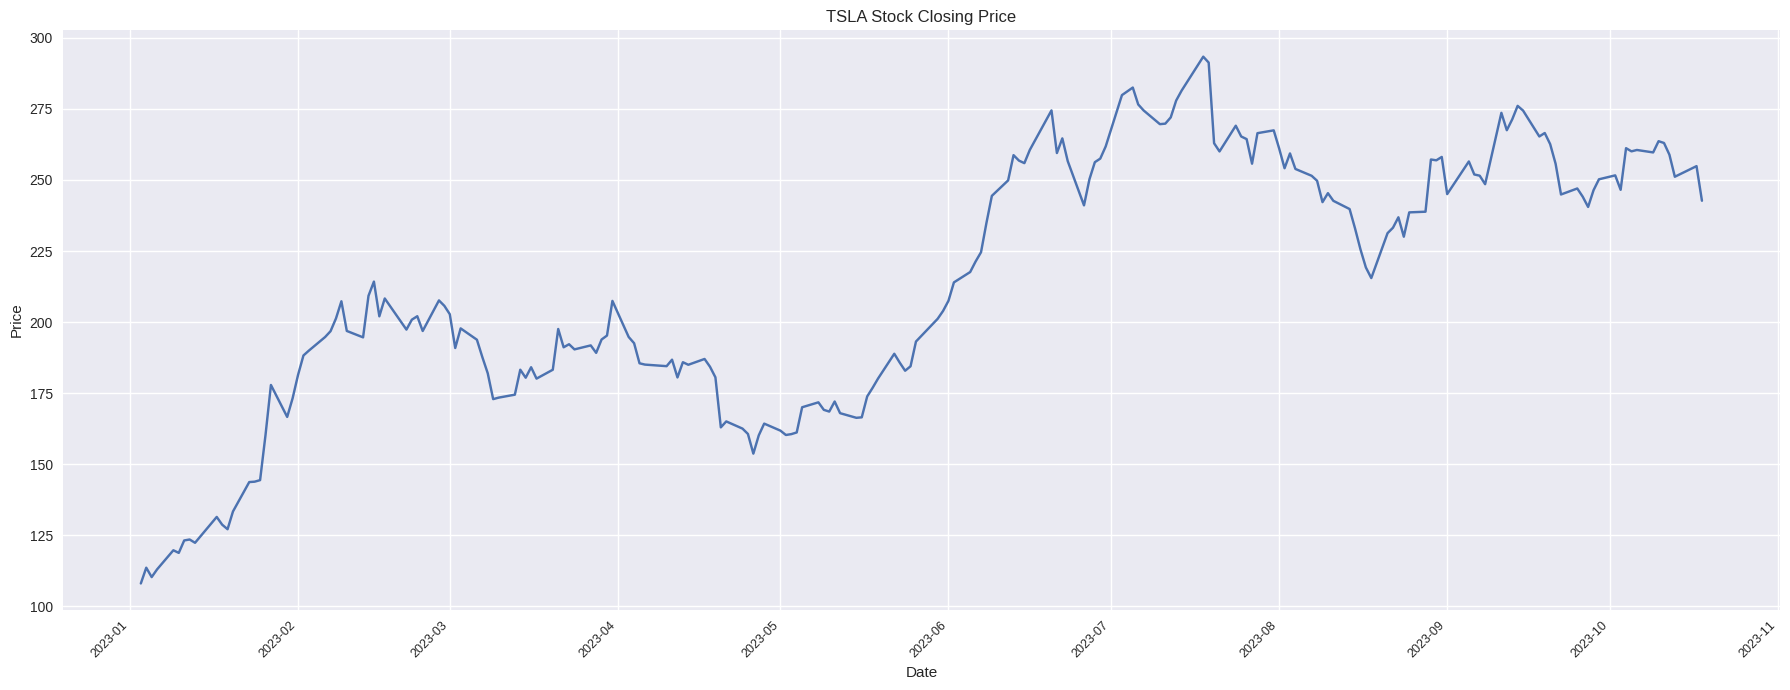

In [ ]:
# Plot the closing price
plt.figure(figsize=(18, 7))
plt.plot(train['Date'], train['Close'])
plt.title(f'{TICKER} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45, ha='right', fontsize=9) # Rotate date labels for better readability

plt.tight_layout()
plt.show()

## 2.1 Add Extra Features

In [ ]:
# # Assuming 'Date' is your date column. If it's named differently, replace 'Date' with the actual column name
# if 'Date' in df.columns:
#     df.set_index('Date', inplace=True)
#     df.index = pd.to_datetime(df.index)
# else:
#     print("No 'Date' column found. Please ensure your DataFrame has a date column.")
#     # You might want to add code here to create a date column if it doesn't exist


# 1. Moving Averages
# df['MA5'] = df['Close'].rolling(window=5).mean()
# df['MA20'] = df['Close'].rolling(window=20).mean()
# df['MA50'] = df['Close'].rolling(window=50).mean()

# # 2. Relative Strength Index (RSI)
# def compute_rsi(data, window=14):
#     diff = data.diff()
#     up = diff.clip(lower=0)
#     down = -1 * diff.clip(upper=0)
#     ema_up = up.ewm(com=window - 1, adjust=False).mean()
#     ema_down = down.ewm(com=window - 1, adjust=False).mean()
#     rs = ema_up / ema_down
#     return 100 - (100 / (1 + rs))

# df['RSI'] = compute_rsi(df['Close'])

# # 3. Bollinger Bands
# df['BB_middle'] = df['Close'].rolling(window=20).mean()
# df['BB_upper'] = df['BB_middle'] + 2 * df['Close'].rolling(window=20).std()
# df['BB_lower'] = df['BB_middle'] - 2 * df['Close'].rolling(window=20).std()

# # 4. Trading Volume Features
# df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()
# df['Volume_Ratio'] = df['Volume'] / df['Volume_MA5']

# # 5. Price Momentum
# df['Price_Momentum'] = df['Close'] - df['Close'].shift(5)

# # 6. Date-based Features
# df['Day_of_Week'] = df.index.dayofweek
# df['Month'] = df.index.month
# df['Quarter'] = df.index.quarter

# # Plot some of the engineered features
# plt.figure(figsize=(15, 10))

# plt.subplot(3, 1, 1)
# plt.plot(df.index, df['Close'], label='Close Price')
# plt.plot(df.index, df['MA5'], label='5-day MA')
# plt.plot(df.index, df['MA20'], label='20-day MA')
# plt.plot(df.index, df['MA50'], label='50-day MA')
# plt.title('TSLA Stock Price with Moving Averages')
# plt.legend()

# plt.subplot(3, 1, 2)
# plt.plot(df.index, df['RSI'], label='RSI')
# plt.title('Relative Strength Index (RSI)')

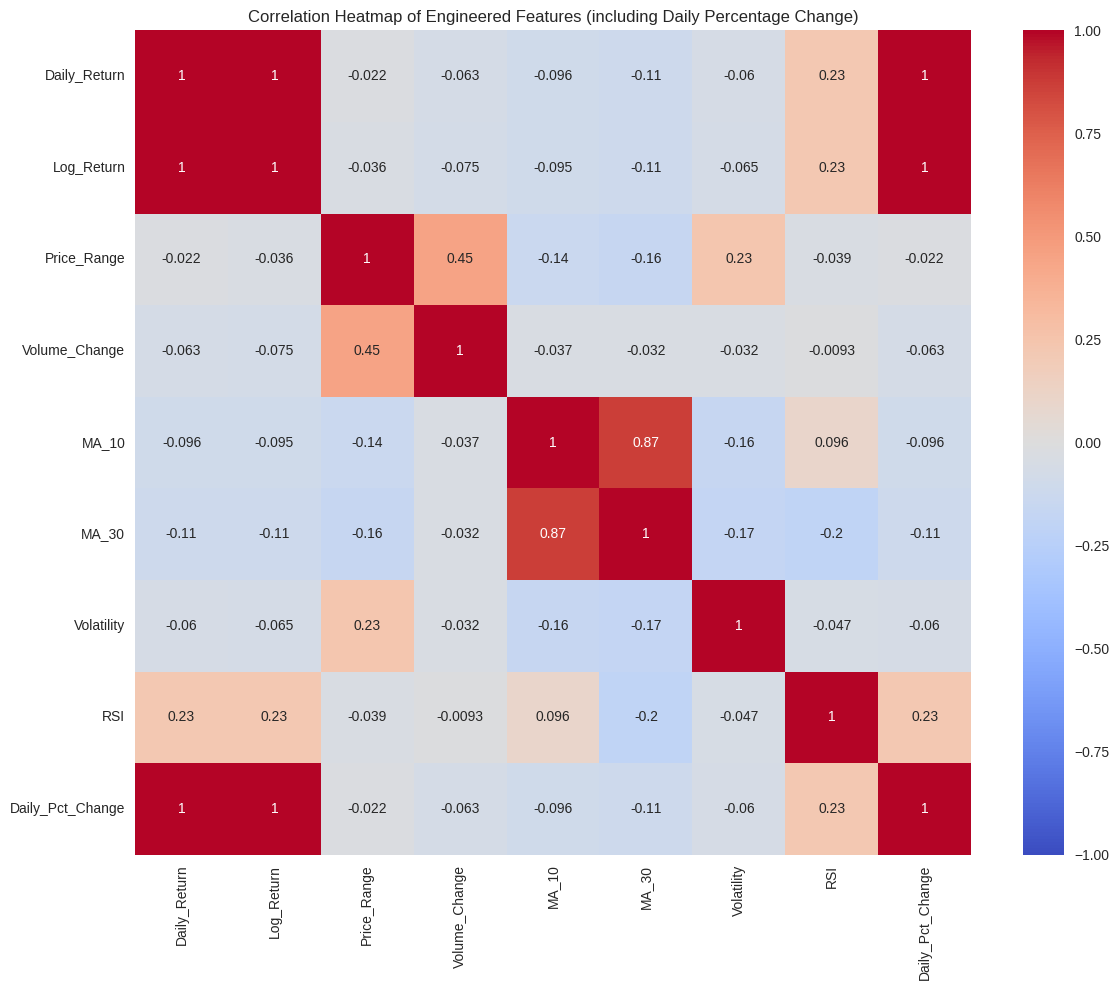

,Daily_Return,Log_Return,Price_Range,Volume_Change,MA_10,MA_30,Volatility,RSI,Daily_Pct_Change
29,0.075062,0.072378,0.106179,0.254994,196.062000,154.817999,0.736308,37.911532,7.506166
30,0.023847,0.023567,0.040376,-0.163772,199.345000,158.356000,0.716839,35.503543,2.384710
31,-0.056946,-0.058631,0.075007,0.268389,200.721999,161.302666,0.764844,21.659554,-5.694554
32,0.031033,0.030562,0.054703,-0.069028,202.554999,164.568333,0.759788,33.136423,3.103348
33,-0.052518,-0.053947,0.060930,-0.157762,202.815999,167.378666,0.777480,22.610382,-5.251789


In [ ]:
# df['Date'] = pd.to_datetime(df['Date'])

# Feature Engineering (including previous features)
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Price_Range'] = (df['High'] - df['Low']) / df['Open']
df['Volume_Change'] = df['Volume'].pct_change()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Daily_Return'].rolling(window=20).std() * np.sqrt(252)
df['RSI'] = 100 - (100 / (1 + df['Daily_Return'].rolling(14).mean() / abs(df['Daily_Return']).rolling(14).mean()))

# Add Daily Percentage Change
df['Daily_Pct_Change'] = df['Close'].pct_change() * 100

# Remove rows with NaN values
df_clean = df.dropna()

# Select features for correlation analysis
features = ['Daily_Return', 'Log_Return', 'Price_Range', 'Volume_Change', 'MA_10', 'MA_30', 'Volatility', 'RSI', 'Daily_Pct_Change']

# Calculate correlation matrix
correlation_matrix = df_clean[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Engineered Features (including Daily Percentage Change)')
plt.tight_layout()
plt.show()

correlation_matrix

# Display the first few rows of the new dataset
df_clean[features].head()

## 2.3 Plot Stock Analysis Charts

In [ ]:
# # Create a figure with 2 rows and 3 columns of subplots
# fig, axs = plt.subplots(2, 3, figsize=(20, 12))
# fig.suptitle('TSLA Stock Analysis', fontsize=16)

# # 1. Moving Averages
# axs[0, 0].plot(df.index, df['Close'], label='Close Price')
# axs[0, 0].plot(df.index, df['MA5'], label='5-day MA')
# axs[0, 0].plot(df.index, df['MA20'], label='20-day MA')
# axs[0, 0].plot(df.index, df['MA50'], label='50-day MA')
# axs[0, 0].set_title('Stock Price with Moving Averages')
# axs[0, 0].legend()

# # 2. RSI
# axs[0, 1].plot(df.index, df['RSI'], label='RSI')
# axs[0, 1].set_title('Relative Strength Index (RSI)')
# axs[0, 1].axhline(y=70, color='r', linestyle='--')
# axs[0, 1].axhline(y=30, color='g', linestyle='--')

# # 3. Bollinger Bands
# axs[0, 2].plot(df.index, df['Close'], label='Close Price')
# axs[0, 2].plot(df.index, df['BB_upper'], label='Upper BB')
# axs[0, 2].plot(df.index, df['BB_middle'], label='Middle BB')
# axs[0, 2].plot(df.index, df['BB_lower'], label='Lower BB')
# axs[0, 2].set_title('Bollinger Bands')
# axs[0, 2].legend()

# # 4. Volume
# axs[1, 0].bar(df.index, df['Volume'], label='Volume')
# axs[1, 0].plot(df.index, df['Volume_MA5'], color='r', label='5-day MA Volume')
# axs[1, 0].set_title('Trading Volume')
# axs[1, 0].legend()

# # 5. Price Momentum
# axs[1, 1].plot(df.index, df['Price_Momentum'], label='Price Momentum')
# axs[1, 1].set_title('Price Momentum (5-day)')
# axs[1, 1].axhline(y=0, color='r', linestyle='--')

# # 6. Volume Ratio
# axs[1, 2].plot(df.index, df['Volume_Ratio'], label='Volume Ratio')
# axs[1, 2].set_title('Volume Ratio')
# axs[1, 2].axhline(y=1, color='r', linestyle='--')

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()

#3. Exploratory Data Analysis

In [ ]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
Daily_Return,1
Log_Return,1
Price_Range,0


## 3.1 AutoCorrelation and Partial Correlation


>* Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

> * Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

### 3.1.1 ACF

Autocorrelation, sometimes known as serial correlation, is the correlation of a time series with a delayed copy of itself as a function of delay. That is, it measures the similarity between observations as a function of the time lag between them. The autocorrelation function can be used basically to detect non-randomness in data and identify cyclical patterns if present.

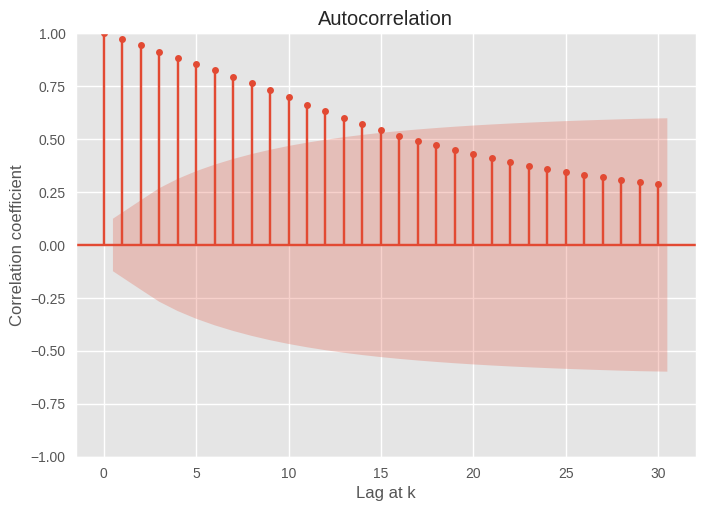

In [ ]:
numerical_data = df['Close']

plt.style.use('ggplot')
plot_acf(numerical_data, lags=30)
plt.ylabel("Correlation coefficient")
plt.xlabel('Lag at k')
plt.show()

### 3.1.2 PACF

The partial autocorrelation function of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y. The autoregressive equation of Y is nothing but the linear regression of Y with its own lags as predictors.

For example, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient α3 of Y_t-3 in the following equation:

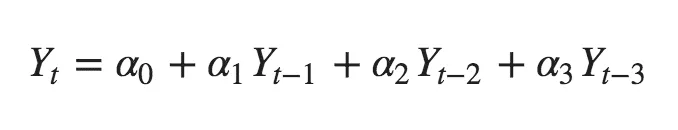

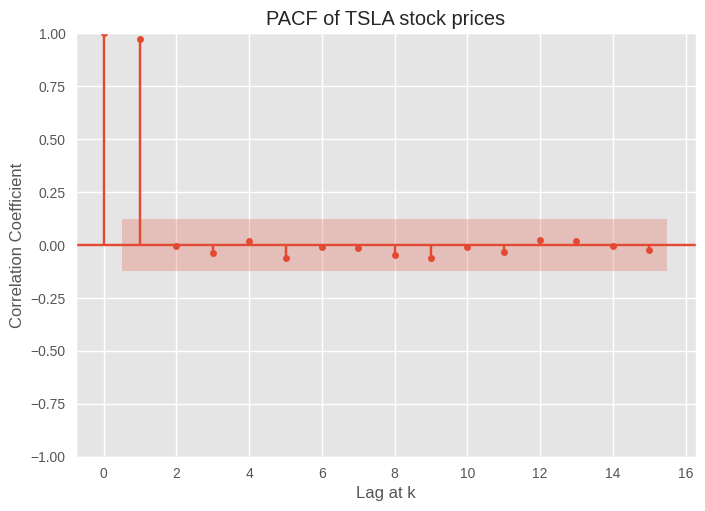

In [ ]:
# numerical_data = df['Close']

plt.style.use('ggplot')
plot_pacf(df['Close'], lags=15)
plt.title("PACF of TSLA stock prices")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show()

## 3.2 Stationarity
Most of the time series are non-stationary either it gives an upward or downward trend or seasonal effect. checking the stationarity is the most important thing that we should handle if we want to make a good prediction of such time serie.

#### 3.2.1 Graphical Analysis

**1**- **Lag Plot**:
The stationarity can be checked by looking at Lag plot. A lag plot is used to checks whether the time series data is random or not, and if the data is correlated with themselves. Random data should not have any identifiable patterns, such as linear.

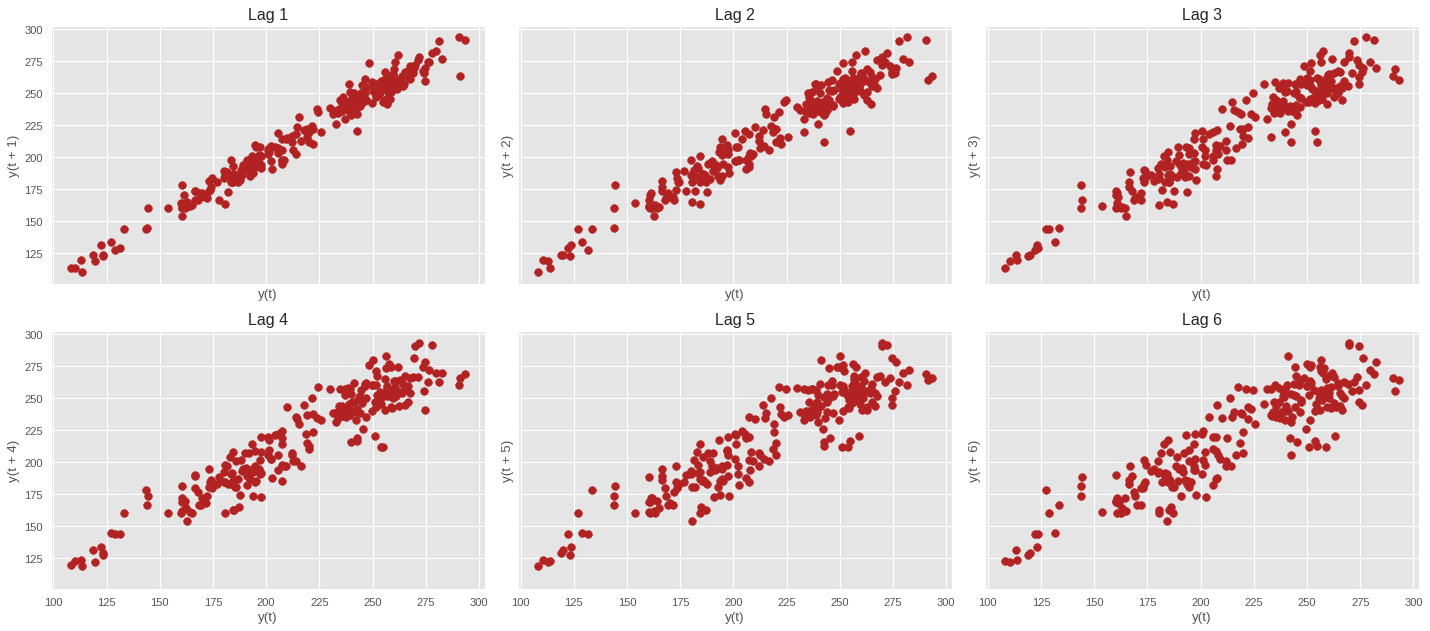

In [ ]:
# numerical_data = df['Close']

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True, dpi=80)
for i, ax in enumerate(axes.flatten()[:6]):
    lag_plot(df['Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.tight_layout()
plt.show()

**2**- **Rolling Statistic**:

we can check for stationarity by looking at how rolling average and rolling standard deviation behave in time.

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Log_Return,Price_Range,Volume_Change,MA_10,MA_30,Volatility,RSI,Daily_Pct_Change
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800,NaN,NaN,0.119524,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000,0.051249,0.049979,0.064797,-0.220455,NaN,NaN,NaN,NaN,5.124885
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300,-0.029039,-0.029469,0.041535,-0.124191,NaN,NaN,NaN,NaN,-2.903910
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100,0.024651,0.024352,0.122136,0.398293,NaN,NaN,NaN,NaN,2.465109
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000,0.059349,0.057655,0.053884,-0.138640,NaN,NaN,NaN,NaN,5.934901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800,-0.007701,-0.007731,0.026679,-0.149136,248.406999,240.767667,0.339685,23.690552,-0.770140
246,2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400,0.016116,0.015988,0.019883,-0.068176,250.093997,242.166333,0.342473,24.160228,1.611623
247,2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400,0.018822,0.018647,0.022528,0.225589,252.536998,243.424000,0.312491,26.575511,1.882241
248,2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900,-0.031594,-0.032104,0.047106,0.066910,253.925998,243.949666,0.332976,14.595950,-3.159428


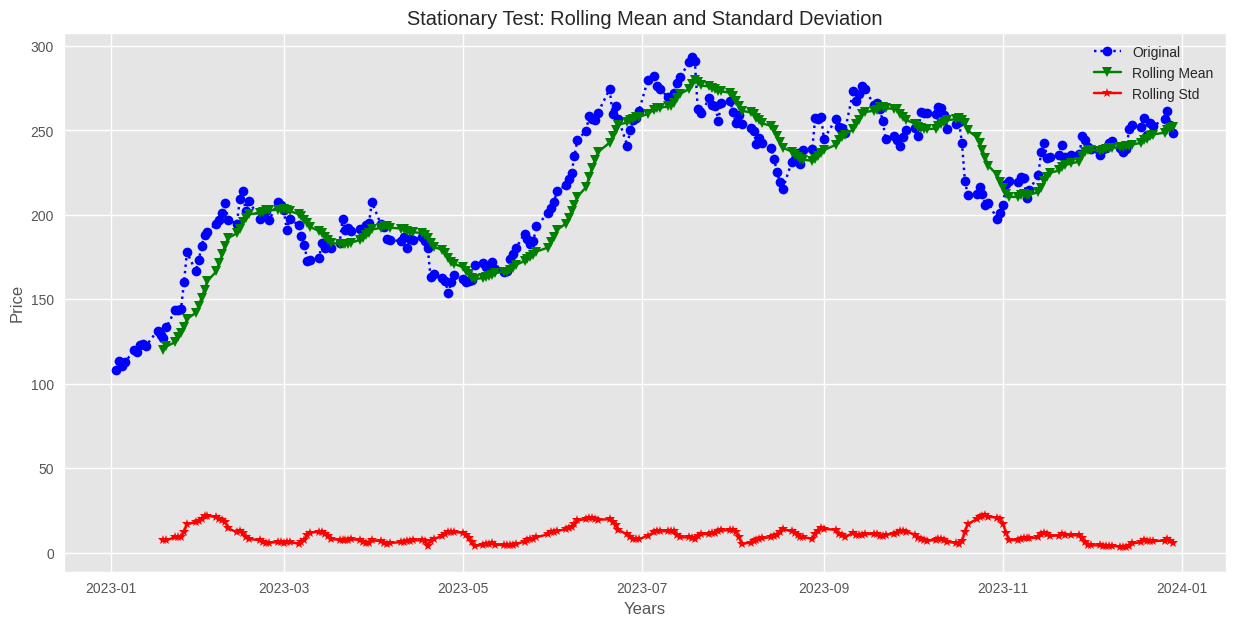

In [ ]:
# Get rolling statistics for window = 12 i.e. yearly statistics
rolling_mean =  df['Close'].rolling(window=12).mean()
rolling_std =  df['Close'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 7))
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Stationary Test: Rolling Mean and Standard Deviation')
plt.plot(df['Date'],  df['Close'], 'b:', marker='o', label='Original')
plt.plot(df['Date'], rolling_mean, 'g-', marker='v', label='Rolling Mean')
plt.plot(df['Date'], rolling_std, 'r-', marker='*', label='Rolling Std')
plt.legend()
plt.show()

## 3.3 Augmented Dickey Fuller test (ADF Test):
Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.

> * Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
> * Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
> * p-value > 0.05: Accept H0, the data has a unit root and is non-stationary
> * p-value ≤ 0.05: Reject H0. the data does not have a unit root and is stationary
> * Test statistics: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series.

In [ ]:
def stationarity_test(time_series):
    # Ensure input is a Series and has no missing values
    time_series = time_series.dropna()

    df_test = adfuller(time_series)

    print('{:25s} {:.6f}'.format("\033[1m ADF Statistic ", df_test[0]))
    print('{:25s} {:.6f}'.format("\033[1m p-value ", df_test[1]))

    if df_test[0] > df_test[4]["5%"]:
        print("\033[36m\033[1mFailed to Reject Ho - Time Series is Non-Stationary\n")
    else:
        print("\033[36m\033[1mReject Ho - Time Series is Stationary\n")

    a = pd.DataFrame([df_test[4]], index=['Critical Values'])
    return a

In [ ]:
# Lets test the stationarity
stationarity_test(df['Close'])

 ADF Statistic        -2.536324
 p-value              0.106885
Failed to Reject Ho - Time Series is Non-Stationary



,1%,5%,10%
Critical Values,-3.456888,-2.873219,-2.572994


**As** we see the test statistic is way above any critica values and the p-value also way above 0.05. then the time serie has an unit root and is non-stationary.

There is many sort of transformations to make the time series stationary for make it able to be modeled.

### 3.3.1 Differencing:
To transform the series using 'Differencing' we will use the diff() method of pandas.

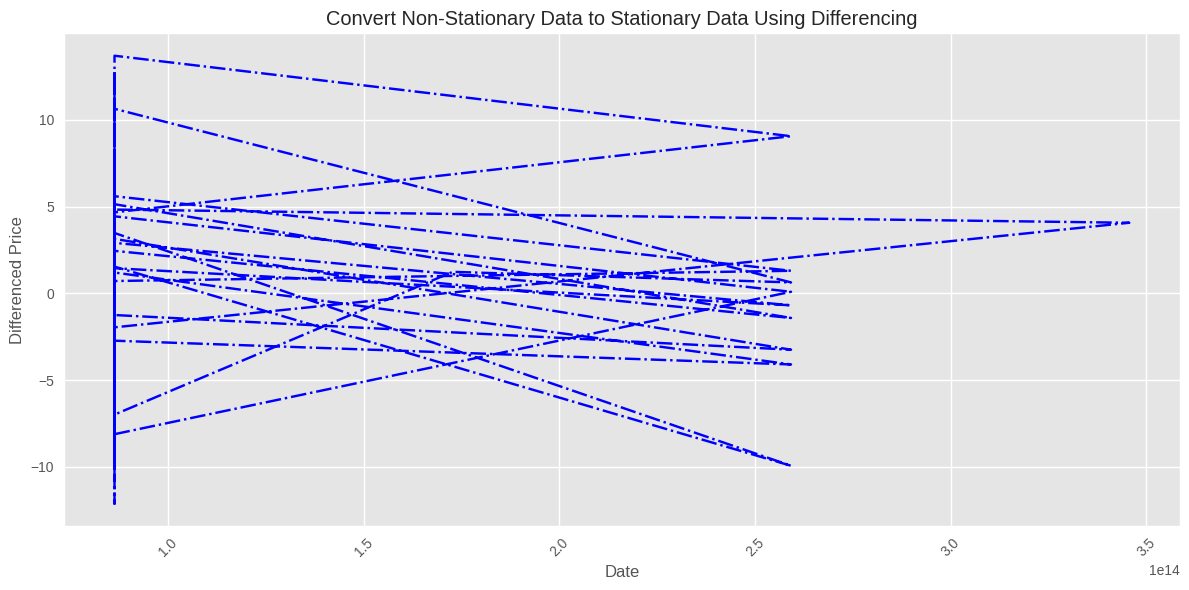

In [ ]:
def plot_differenced_data(df):
    # Ensure 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Ensure 'Close' column is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Drop rows with NaN values that may result from conversion
    df = df.dropna(subset=['Close'])

    # First order differencing
    df_tsla_stock = df[['Date', 'Close']].diff(1).bfill()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_tsla_stock['Date'], df_tsla_stock['Close'], 'b-.')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.title('Convert Non-Stationary Data to Stationary Data Using Differencing')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_differenced_data(test)

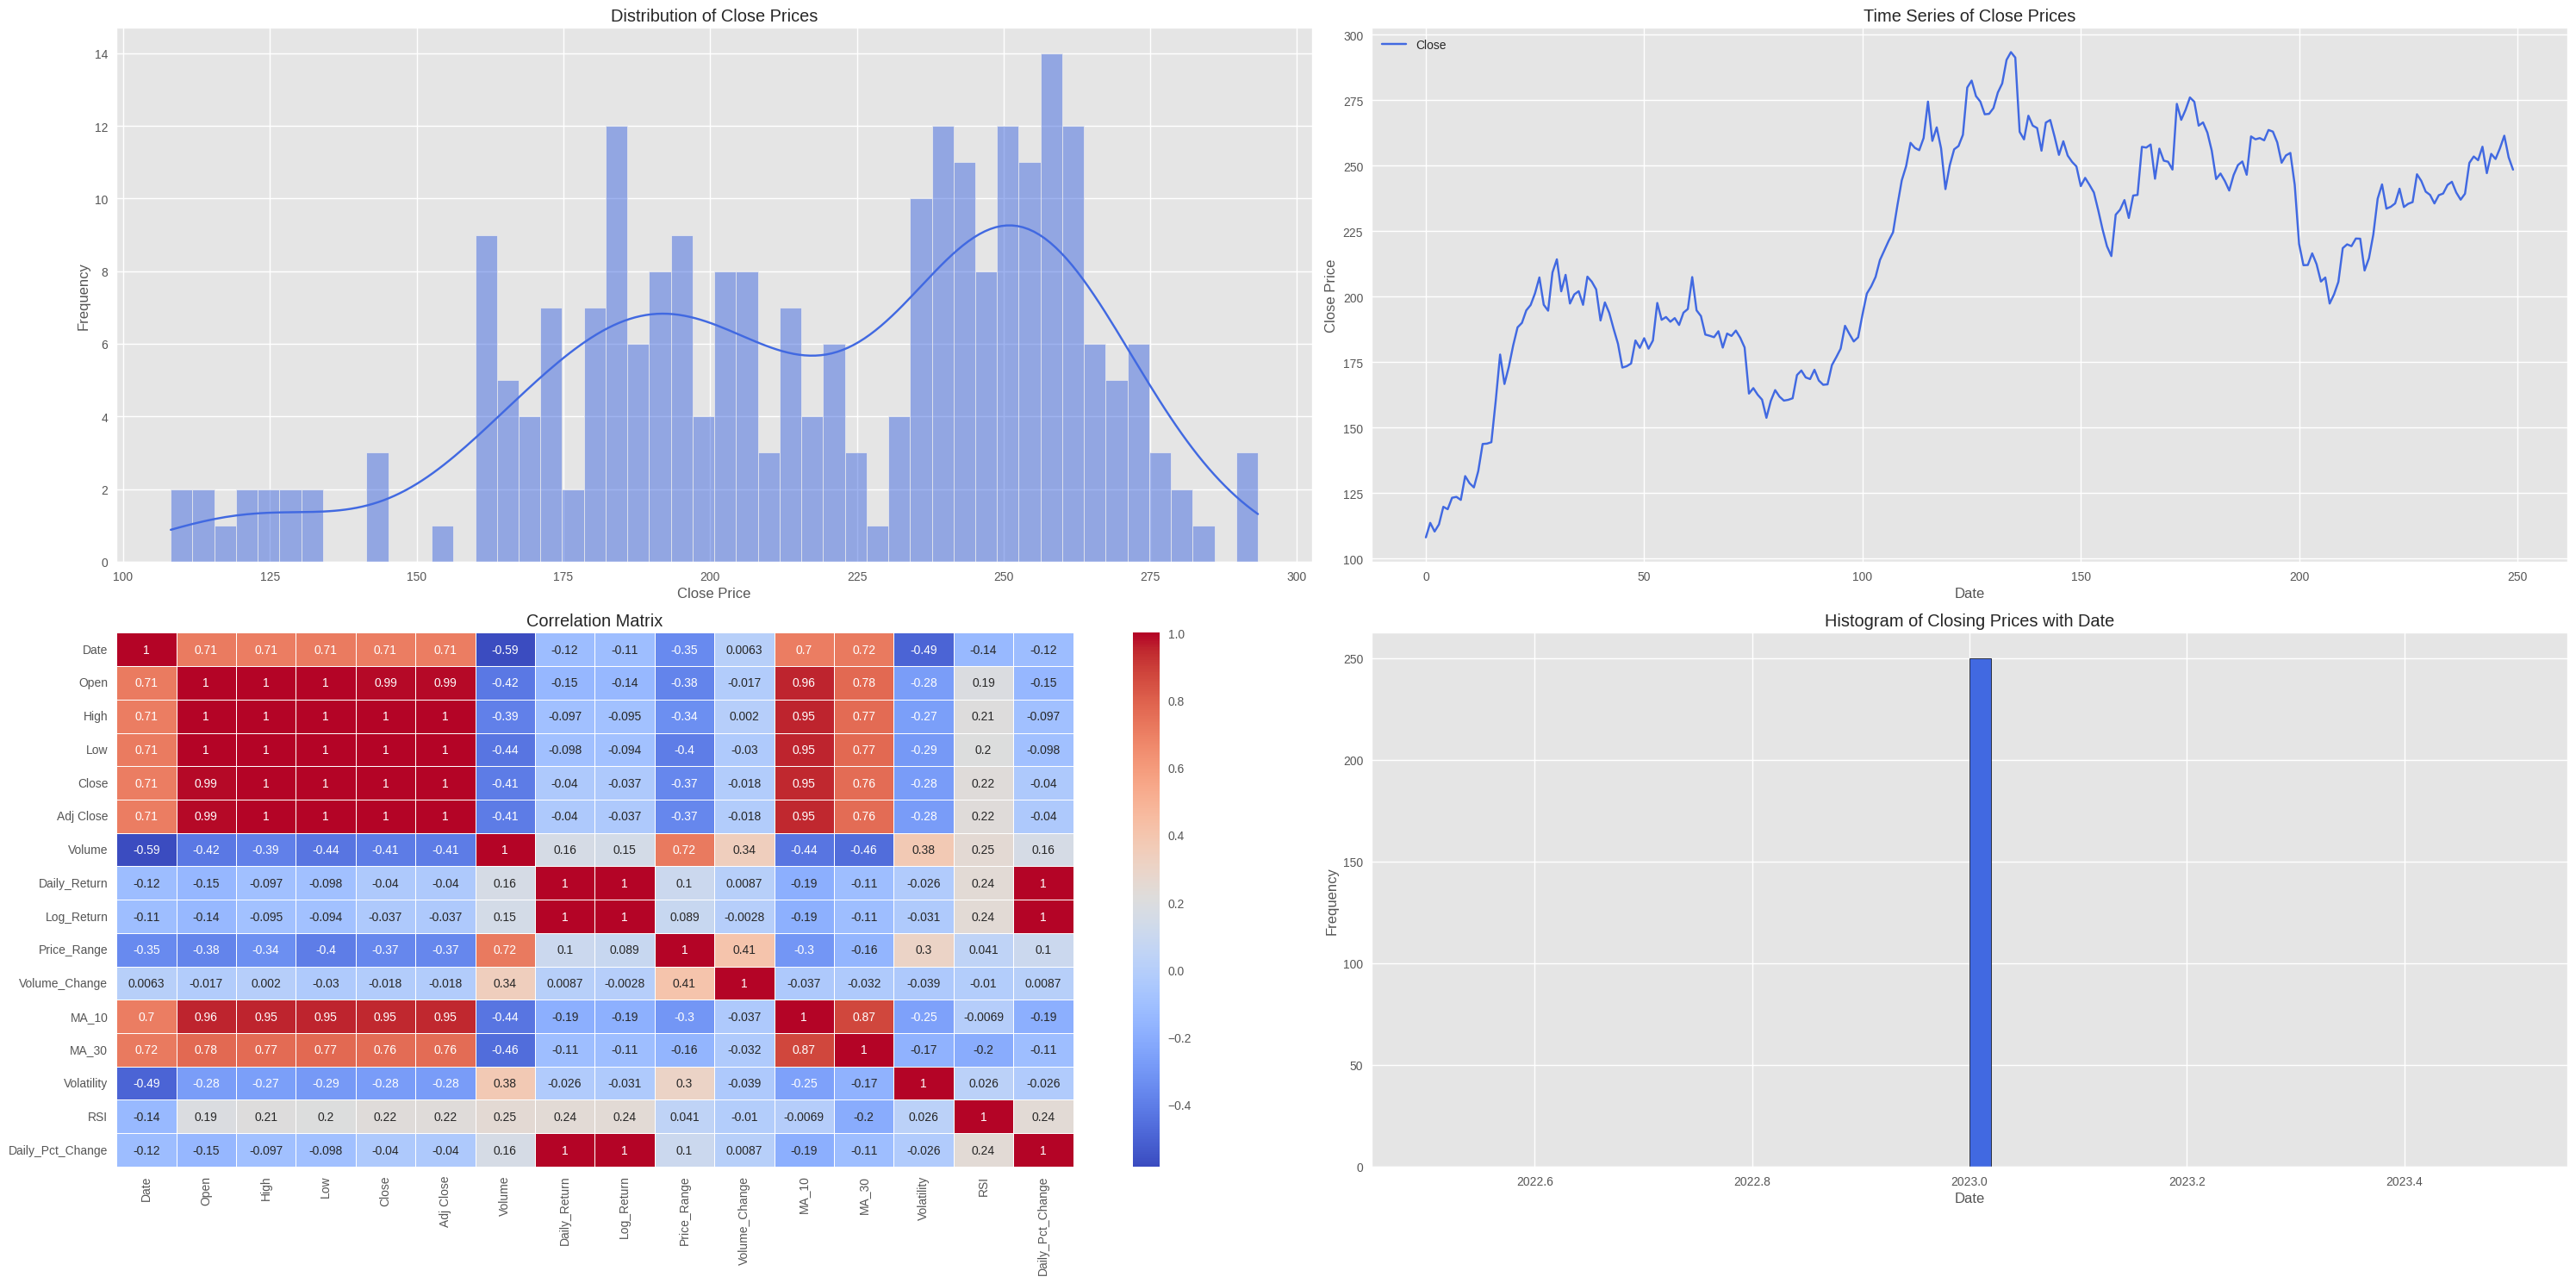

In [ ]:
def plot_charts(df):

    # Create a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(30, 15))

    # Plot the distribution of the 'Close' prices
    sns.histplot(df['Close'], bins=50, kde=True, color='royalblue', ax=axs[0, 0])
    axs[0, 0].set_title('Distribution of Close Prices')
    axs[0, 0].set_xlabel('Close Price')
    axs[0, 0].set_ylabel('Frequency')

    # Plot the time series of the 'Close' prices
    df['Close'].plot(ax=axs[0, 1], color='royalblue', legend=True)
    axs[0, 1].set_title('Time Series of Close Prices')
    axs[0, 1].set_xlabel('Date')
    axs[0, 1].set_ylabel('Close Price')
    axs[0, 1].legend(['Close'], loc='upper left')

    # Plot the correlation matrix
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, ax=axs[1, 0])
    axs[1, 0].set_title('Correlation Matrix')

    # Plot the histogram of closing prices with date
    df.reset_index()['Date'].map(lambda x: x.year).hist(bins=50, color='royalblue', edgecolor='black', ax=axs[1, 1])
    axs[1, 1].set_title('Histogram of Closing Prices with Date')
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].grid(True)

    # Adjust layout
    plt.tight_layout()
    return plt.show()

plot_charts(df)

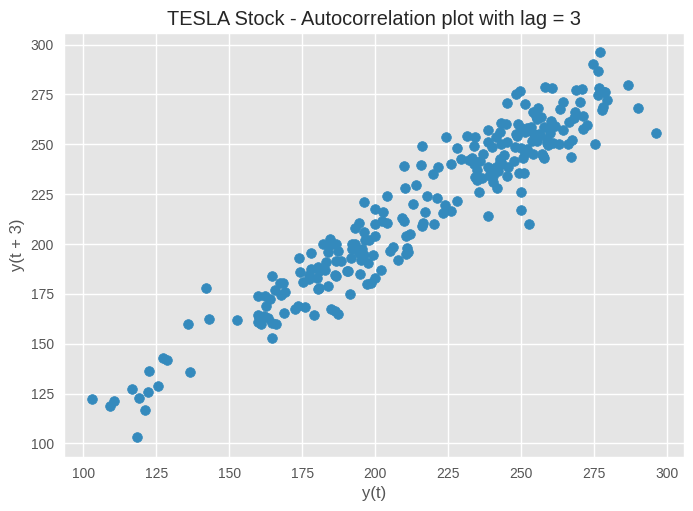

In [ ]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

# 4. Autoregressive Integrated Moving Average (ARIMA)


## 4.1 Simple ARIMA

In [ ]:
class ArimaModel:
    def __init__(self, train, test, target_column):
        """
        Initializes the ARIMAModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for ARIMA modeling.
        """
        # Ensure the target column exists
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Extract the target column as a Series and ensure data is numeric and clean
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()

        # If necessary, convert the index to datetime
        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')  # Avoid division by zero

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))  # Avoid division by zero

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.forecast(steps=len(self.test))
            mse = mean_squared_error(self.test, forecast)
            mae = mean_absolute_error(self.test, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.test - forecast) / self.test)) * 100 if not np.all(self.test == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.test, forecast)
            mase = self.mean_absolute_scaled_error(self.test, forecast)
            r_squared = r2_score(self.test, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.test), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order {order}: {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMA model order based on the lowest MSE.
        """
        p = d = q = range(0, 3)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMA(p={p}, d={d}, q={q}) MSE: {mse:.4f}')  # Display the ARIMA order and MSE

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")


    def fit_best_model(self):
        """
        Fits the best ARIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test))

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMA (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMA order
        plt.title(f'Stock Price Forecast (ARIMA Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMA Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()


    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMA model orders with the lowest MSE:")
        display(top_results)

        return top_results


In [ ]:
arima_model = ArimaModel(train, test, target_column='Close')

In [ ]:
# Perform grid search
arima_model.grid_search()

ARIMA(p=0, d=0, q=0) MSE: 645.6008
ARIMA(p=0, d=0, q=1) MSE: 653.0990
ARIMA(p=0, d=0, q=2) MSE: 665.4892
ARIMA(p=0, d=1, q=0) MSE: 369.7784
ARIMA(p=0, d=1, q=1) MSE: 377.3729
ARIMA(p=0, d=1, q=2) MSE: 375.5880
ARIMA(p=0, d=2, q=0) MSE: 126729.6313
ARIMA(p=0, d=2, q=1) MSE: 435.6493
ARIMA(p=0, d=2, q=2) MSE: 406.8940
ARIMA(p=1, d=0, q=0) MSE: 433.7626
ARIMA(p=1, d=0, q=1) MSE: 428.8215
ARIMA(p=1, d=0, q=2) MSE: 431.0466
ARIMA(p=1, d=1, q=0) MSE: 377.3451
ARIMA(p=1, d=1, q=1) MSE: 370.9199
ARIMA(p=1, d=1, q=2) MSE: 360.9637
ARIMA(p=1, d=2, q=0) MSE: 50121.5337
ARIMA(p=1, d=2, q=1) MSE: 378.7538
ARIMA(p=1, d=2, q=2) MSE: 383.0216
ARIMA(p=2, d=0, q=0) MSE: 428.7914
ARIMA(p=2, d=0, q=1) MSE: 427.1180
ARIMA(p=2, d=0, q=2) MSE: 434.9096
ARIMA(p=2, d=1, q=0) MSE: 375.0705
ARIMA(p=2, d=1, q=1) MSE: 346.7430
ARIMA(p=2, d=1, q=2) MSE: 341.2676
ARIMA(p=2, d=2, q=0) MSE: 22428.4869
ARIMA(p=2, d=2, q=1) MSE: 558.4805
ARIMA(p=2, d=2, q=2) MSE: 402.9085
Best order found: (2, 1, 2) with MSE: 341.2676


In [ ]:
# Fit the best model
arima_model.fit_best_model()

In [ ]:
# Make forecast and plot results
arima_model.make_forecast()

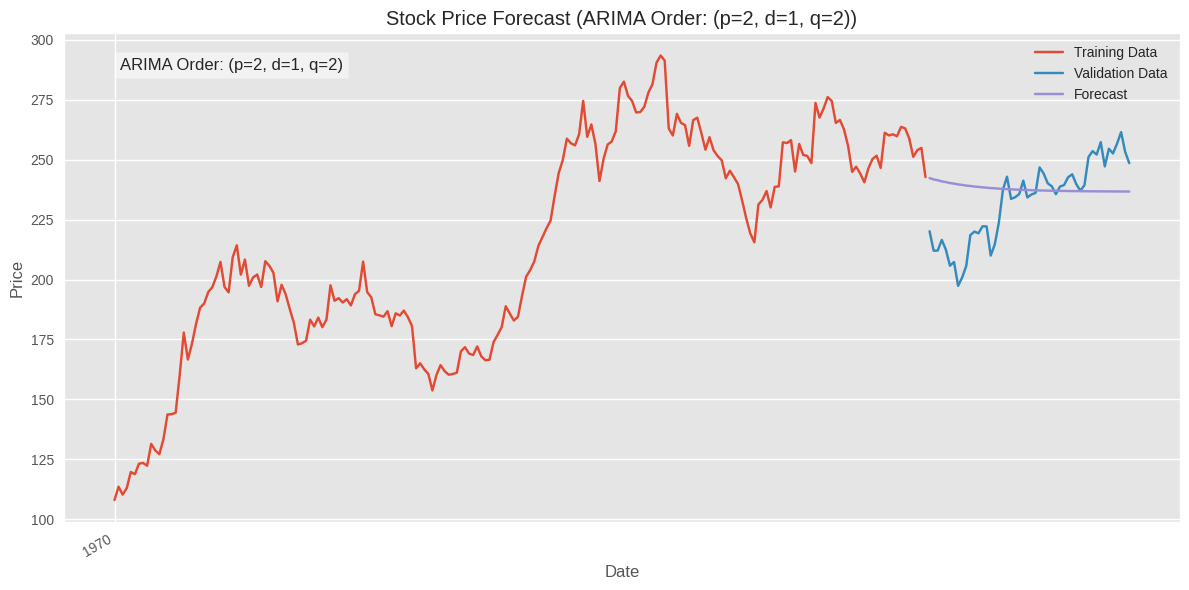

In [ ]:
arima_model.plot_results()

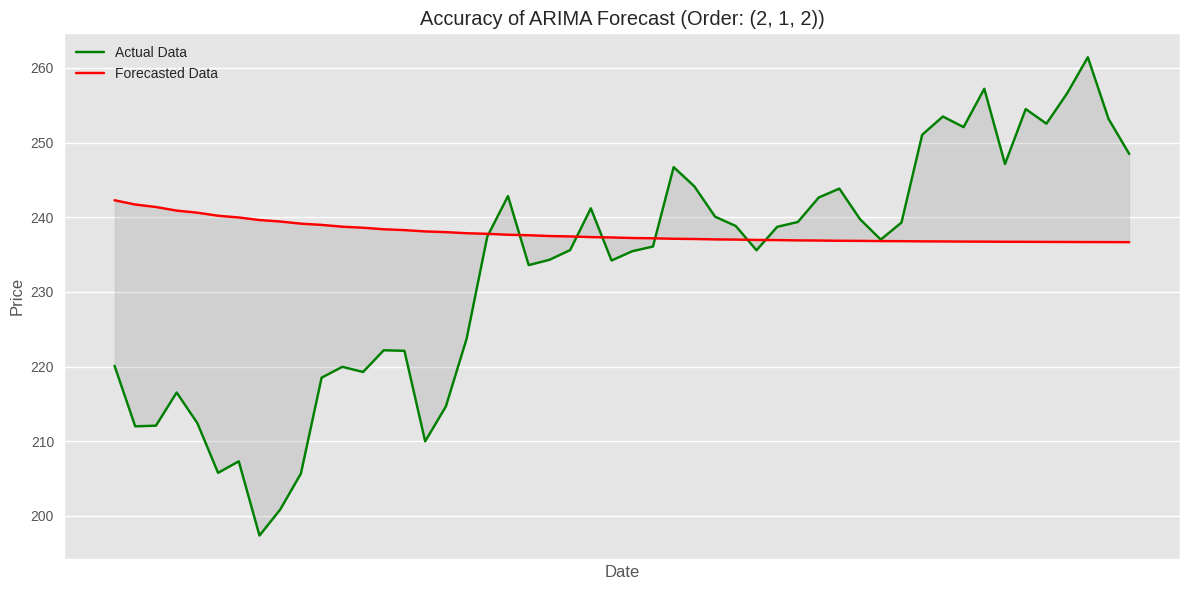

In [ ]:
arima_model.plot_accuracy()

In [ ]:
# Print evaluation metrics and model summary
arima_model.print_evaluation_metrics()

Final Mean Squared Error: 341.2676461781428
Final Mean Absolute Error: 14.511479788009924
Final Root Mean Squared Error: 18.473430817748575


In [ ]:
arima_model.print_model_summary()

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                  200
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.421
Date:                Wed, 14 Aug 2024   AIC                           1352.842
Time:                        02:15:47   BIC                           1369.309
Sample:                    01-01-1970   HQIC                          1359.507
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0086      0.172     -0.050      0.960      -0.345       0.328
ar.L2          0.8487      0.169      5.013      0.000       0.517       1.180
ma.L1         -0.0025      0.208     -0.012      0.991

In [ ]:
# Display the top 5 model orders
arima_model.display_top_orders()

Top 5 ARIMA model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
23,"(2, 1, 2)",341.267646,14.511480,18.473431,6.501958,6.270000,3.051115,-0.245284,-0.326498,1352.842204,1369.308728
22,"(2, 1, 1)",346.742955,14.605324,18.621035,6.546502,6.308752,3.070847,-0.265264,-0.347781,1353.022128,1366.195348
14,"(1, 1, 2)",360.963703,14.620676,18.999045,6.633542,6.310862,3.074075,-0.317155,-0.403056,1352.379169,1365.552388
3,"(0, 1, 0)",369.778429,14.787396,19.229624,6.715016,6.379336,3.109128,-0.349320,-0.437319,1349.497662,1352.790967
13,"(1, 1, 1)",370.919950,14.811966,19.259282,6.726739,6.389423,3.114294,-0.353485,-0.441756,1350.592564,1360.472478


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
23,"(2, 1, 2)",341.267646,14.511480,18.473431,6.501958,6.270000,3.051115,-0.245284,-0.326498,1352.842204,1369.308728
22,"(2, 1, 1)",346.742955,14.605324,18.621035,6.546502,6.308752,3.070847,-0.265264,-0.347781,1353.022128,1366.195348
14,"(1, 1, 2)",360.963703,14.620676,18.999045,6.633542,6.310862,3.074075,-0.317155,-0.403056,1352.379169,1365.552388
3,"(0, 1, 0)",369.778429,14.787396,19.229624,6.715016,6.379336,3.109128,-0.349320,-0.437319,1349.497662,1352.790967
13,"(1, 1, 1)",370.919950,14.811966,19.259282,6.726739,6.389423,3.114294,-0.353485,-0.441756,1350.592564,1360.472478


## 4.2 ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)


In [ ]:
class ARIMAXModel:

    def __init__(self, train, test, train_exog, test_exog, target_column, exog_vars):
        """
        Initializes the ARIMAXModel with the given parameters.
        """
        # Ensure the target column exists in the provided DataFrames
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column
        self.exog_vars = exog_vars

        # Convert the Date column to datetime if not already done
        if not isinstance(train.index, pd.DatetimeIndex):
            train.index = pd.to_datetime(train.index)
        if not isinstance(test.index, pd.DatetimeIndex):
            test.index = pd.to_datetime(test.index)

        # Reindex the exogenous variables to ensure they match the target column's index
        train_exog = train_exog.reindex(train.index)
        test_exog = test_exog.reindex(test.index)

        # Drop any rows with missing values in exogenous variables or the target variable
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()

        self.train_exog = train_exog.loc[self.train.index].dropna()
        self.test_exog = test_exog.loc[self.test.index].dropna()

        # Ensure the train_exog and test_exog indices match the train and test indices
        self.train_exog = self.train_exog.reindex(self.train.index)
        self.test_exog = self.test_exog.reindex(self.test.index)

        # Drop any rows where exogenous variables do not match the target variable indices
        self.train, self.train_exog = self.train.align(self.train_exog, join='inner', axis=0)
        self.test, self.test_exog = self.test.align(self.test_exog, join='inner', axis=0)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])


    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')  # Avoid division by zero

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))  # Avoid division by zero

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            results = model.fit()
            forecast = results.fittedvalues
            mse = mean_squared_error(self.train, forecast)
            mae = mean_absolute_error(self.train, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.train - forecast) / self.train)) * 100 if not np.all(self.train == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.train, forecast)
            mase = self.mean_absolute_scaled_error(self.train, forecast)
            r_squared = r2_score(self.train, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.train), len(order))
            aic_value = results.aic
            bic_value = results.bic

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order (p={order[0]}, d={order[1]}, q={order[2]}): {e}")
            return None

    def grid_search(self):
        """
        Performs a grid search to find the most optimal ARIMAX model order based on the lowest MSE.
        """
        p = d = q = range(0, 6)
        pdq = list(itertools.product(p, d, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param  # Unpack the current order
                model = ARIMA(self.train, exog=self.train_exog, order=param)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'ARIMAX(p={p}, d={d}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")

    def fit_best_model(self):
        """
        Fits the best ARIMAX model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = ARIMA(self.train, exog=self.train_exog, order=self.best_order)
        self.best_model = self.best_model.fit()

    def make_forecast(self):
        """
        Makes forecast using the best fitted ARIMAX model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.forecast(steps=len(self.test), exog=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the ARIMAX (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with ARIMAX order
        plt.title(f'Stock Price Forecast (ARIMAX Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'ARIMAX Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of ARIMAX Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'ARIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'ARIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "ARIMAX")

        # Print the modified summary
        modified_summary

        # Extract and print coefficients
        print("Model Coefficients:")
        for param_name, value in zip(self.best_model.model.param_names, self.best_model.params):
            print(f"{param_name}: {value:.4f}")

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMAX model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} ARIMAX model orders with the lowest MSE:")
        display(top_results)

        return top_results


    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

In [ ]:
train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
1,2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
2,2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300
3,2023-01-06,103.000000,114.389999,101.809998,113.059998,113.059998,220911100
4,2023-01-09,118.959999,123.519997,117.110001,119.769997,119.769997,190284000
...,...,...,...,...,...,...,...
195,2023-10-12,262.920013,265.410004,256.630005,258.869995,258.869995,111508100
196,2023-10-13,258.899994,259.600006,250.220001,251.119995,251.119995,102073800
197,2023-10-16,250.050003,255.399994,248.479996,253.919998,253.919998,88917200
198,2023-10-17,250.100006,257.179993,247.080002,254.850006,254.850006,93562900


In [ ]:
test

,Date,Open,High,Low,Close,Adj Close,Volume
200,2023-10-19,225.949997,230.610001,216.779999,220.110001,220.110001,170772700
201,2023-10-20,217.009995,218.860001,210.419998,211.990005,211.990005,137734000
202,2023-10-23,210.000000,216.979996,202.509995,212.080002,212.080002,150683400
203,2023-10-24,216.500000,222.050003,214.110001,216.520004,216.520004,118231100
204,2023-10-25,215.880005,220.100006,212.199997,212.419998,212.419998,107065100
205,2023-10-26,211.320007,214.800003,204.880005,205.759995,205.759995,115112600
206,2023-10-27,210.600006,212.410004,205.770004,207.300003,207.300003,94881200
207,2023-10-30,209.279999,210.880005,194.669998,197.360001,197.360001,136448200
208,2023-10-31,196.119995,202.800003,194.070007,200.839996,200.839996,118068300
209,2023-11-01,204.039993,205.990005,197.850006,205.660004,205.660004,121661700


In [ ]:
train[['Open', 'High', 'Low', 'Adj Close', 'Volume']]

,Open,High,Low,Adj Close,Volume
0,118.470001,118.800003,104.639999,108.099998,231402800
1,109.110001,114.589996,107.519997,113.639999,180389000
2,110.510002,111.750000,107.160004,110.339996,157986300
3,103.000000,114.389999,101.809998,113.059998,220911100
4,118.959999,123.519997,117.110001,119.769997,190284000
...,...,...,...,...,...
195,262.920013,265.410004,256.630005,258.869995,111508100
196,258.899994,259.600006,250.220001,251.119995,102073800
197,250.050003,255.399994,248.479996,253.919998,88917200
198,250.100006,257.179993,247.080002,254.850006,93562900


In [ ]:
# Define exogenous variables
exog_vars = ['Open', 'High', 'Low', 'Adj Close', 'Volume']

# Initialize the ARIMAX model
arimax_model = ARIMAXModel(train, test, train[exog_vars], test[exog_vars], target_column='Close', exog_vars=exog_vars)

In [ ]:
# Perform grid search
arimax_model.grid_search()

ARIMAX(p=0, d=0, q=0) MSE: 0.0000
ARIMAX(p=0, d=0, q=1) MSE: 0.0000
ARIMAX(p=0, d=0, q=2) MSE: 0.0000
ARIMAX(p=0, d=0, q=3) MSE: 0.0000
ARIMAX(p=0, d=0, q=4) MSE: 0.0000
ARIMAX(p=0, d=0, q=5) MSE: 0.0000
ARIMAX(p=0, d=1, q=0) MSE: 0.0000
ARIMAX(p=0, d=1, q=1) MSE: 0.0000
ARIMAX(p=0, d=1, q=2) MSE: 0.0000
ARIMAX(p=0, d=1, q=3) MSE: 0.0000
ARIMAX(p=0, d=1, q=4) MSE: 0.0000
ARIMAX(p=0, d=1, q=5) MSE: 0.0000
ARIMAX(p=0, d=2, q=0) MSE: 0.0000
ARIMAX(p=0, d=2, q=1) MSE: 0.0000
ARIMAX(p=0, d=2, q=2) MSE: 0.0000
ARIMAX(p=0, d=2, q=3) MSE: 0.0000
ARIMAX(p=0, d=2, q=4) MSE: 0.0000
ARIMAX(p=0, d=2, q=5) MSE: 0.0000
ARIMAX(p=0, d=3, q=0) MSE: 0.0000
ARIMAX(p=0, d=3, q=1) MSE: 0.0000
ARIMAX(p=0, d=3, q=2) MSE: 0.0000
ARIMAX(p=0, d=3, q=3) MSE: 0.0000
ARIMAX(p=0, d=3, q=4) MSE: 0.0000
ARIMAX(p=0, d=3, q=5) MSE: 0.0000
ARIMAX(p=0, d=4, q=0) MSE: 0.0005
ARIMAX(p=0, d=4, q=1) MSE: 0.0005
ARIMAX(p=0, d=4, q=2) MSE: 0.0005
ARIMAX(p=0, d=4, q=3) MSE: 0.0000
ARIMAX(p=0, d=4, q=4) MSE: 0.0000
ARIMAX(p=0, d=

In [ ]:
# Display top orders
top_orders = arimax_model.display_top_orders()

# Fit the best model
arimax_model.fit_best_model()

Top 5 ARIMAX model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
42,"(1, 1, 0)",2.944434e-19,3.625075e-10,5.426264e-10,1.957590e-10,1.957590e-10,6.692176e-11,1.0,1.0,-4182.447419,-4159.394285
78,"(2, 1, 0)",3.039199e-19,3.670601e-10,5.512893e-10,2.020901e-10,2.020901e-10,6.776222e-11,1.0,1.0,-4181.673952,-4155.327514
154,"(4, 1, 4)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4167.218825,-4121.112557
83,"(2, 1, 5)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4169.218825,-4126.405862
116,"(3, 1, 2)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4173.218825,-4136.992471


In [ ]:
# Make forecast
arimax_model.make_forecast()

In [ ]:
# Display model summary
arimax_model.print_model_summary()

Model Coefficients:
Open: 0.0000
High: -0.0000
Low: -0.0000
Adj Close: 1.0000
Volume: 0.0000
ar.L1: -0.3629
sigma2: 0.0000


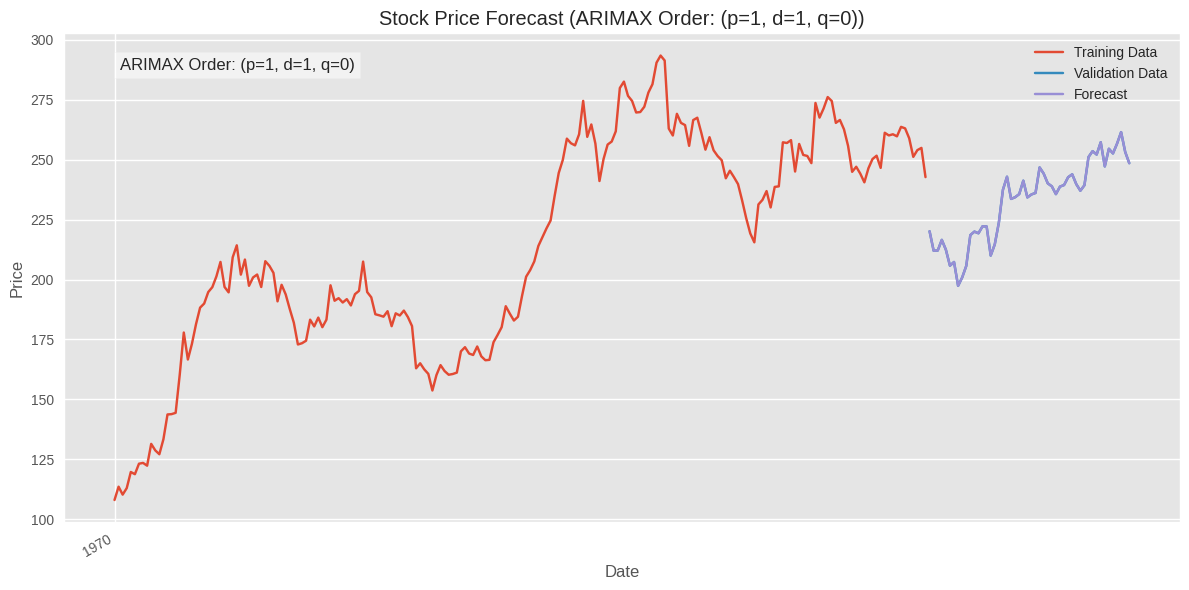

In [ ]:
# Plot results
arimax_model.plot_results()

In [ ]:
# Perform grid search
arimax_model.grid_search()

ARIMAX(p=0, d=0, q=0) MSE: 0.0000
ARIMAX(p=0, d=0, q=1) MSE: 0.0000
ARIMAX(p=0, d=0, q=2) MSE: 0.0000
ARIMAX(p=0, d=0, q=3) MSE: 0.0000
ARIMAX(p=0, d=0, q=4) MSE: 0.0000
ARIMAX(p=0, d=0, q=5) MSE: 0.0000
ARIMAX(p=0, d=1, q=0) MSE: 0.0000
ARIMAX(p=0, d=1, q=1) MSE: 0.0000
ARIMAX(p=0, d=1, q=2) MSE: 0.0000
ARIMAX(p=0, d=1, q=3) MSE: 0.0000
ARIMAX(p=0, d=1, q=4) MSE: 0.0000
ARIMAX(p=0, d=1, q=5) MSE: 0.0000
ARIMAX(p=0, d=2, q=0) MSE: 0.0000
ARIMAX(p=0, d=2, q=1) MSE: 0.0000
ARIMAX(p=0, d=2, q=2) MSE: 0.0000
ARIMAX(p=0, d=2, q=3) MSE: 0.0000
ARIMAX(p=0, d=2, q=4) MSE: 0.0000
ARIMAX(p=0, d=2, q=5) MSE: 0.0000
ARIMAX(p=0, d=3, q=0) MSE: 0.0000
ARIMAX(p=0, d=3, q=1) MSE: 0.0000
ARIMAX(p=0, d=3, q=2) MSE: 0.0000
ARIMAX(p=0, d=3, q=3) MSE: 0.0000
ARIMAX(p=0, d=3, q=4) MSE: 0.0000
ARIMAX(p=0, d=3, q=5) MSE: 0.0000
ARIMAX(p=0, d=4, q=0) MSE: 0.0005
ARIMAX(p=0, d=4, q=1) MSE: 0.0005
ARIMAX(p=0, d=4, q=2) MSE: 0.0005
ARIMAX(p=0, d=4, q=3) MSE: 0.0000
ARIMAX(p=0, d=4, q=4) MSE: 0.0000
ARIMAX(p=0, d=

In [ ]:
# Fit the best model
arimax_model.fit_best_model()

In [ ]:
# Display the top 5 model orders
arimax_model.display_top_orders()

Top 5 ARIMAX model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
42,"(1, 1, 0)",2.944434e-19,3.625075e-10,5.426264e-10,1.957590e-10,1.957590e-10,6.692176e-11,1.0,1.0,-4182.447419,-4159.394285
78,"(2, 1, 0)",3.039199e-19,3.670601e-10,5.512893e-10,2.020901e-10,2.020901e-10,6.776222e-11,1.0,1.0,-4181.673952,-4155.327514
154,"(4, 1, 4)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4167.218825,-4121.112557
83,"(2, 1, 5)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4169.218825,-4126.405862
116,"(3, 1, 2)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4173.218825,-4136.992471


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
42,"(1, 1, 0)",2.944434e-19,3.625075e-10,5.426264e-10,1.957590e-10,1.957590e-10,6.692176e-11,1.0,1.0,-4182.447419,-4159.394285
78,"(2, 1, 0)",3.039199e-19,3.670601e-10,5.512893e-10,2.020901e-10,2.020901e-10,6.776222e-11,1.0,1.0,-4181.673952,-4155.327514
154,"(4, 1, 4)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4167.218825,-4121.112557
83,"(2, 1, 5)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4169.218825,-4126.405862
116,"(3, 1, 2)",3.320336e-19,4.002177e-10,5.762236e-10,2.183291e-10,2.183291e-10,7.388338e-11,1.0,1.0,-4173.218825,-4136.992471


In [ ]:
# Make forecast and plot results
arimax_model.make_forecast()

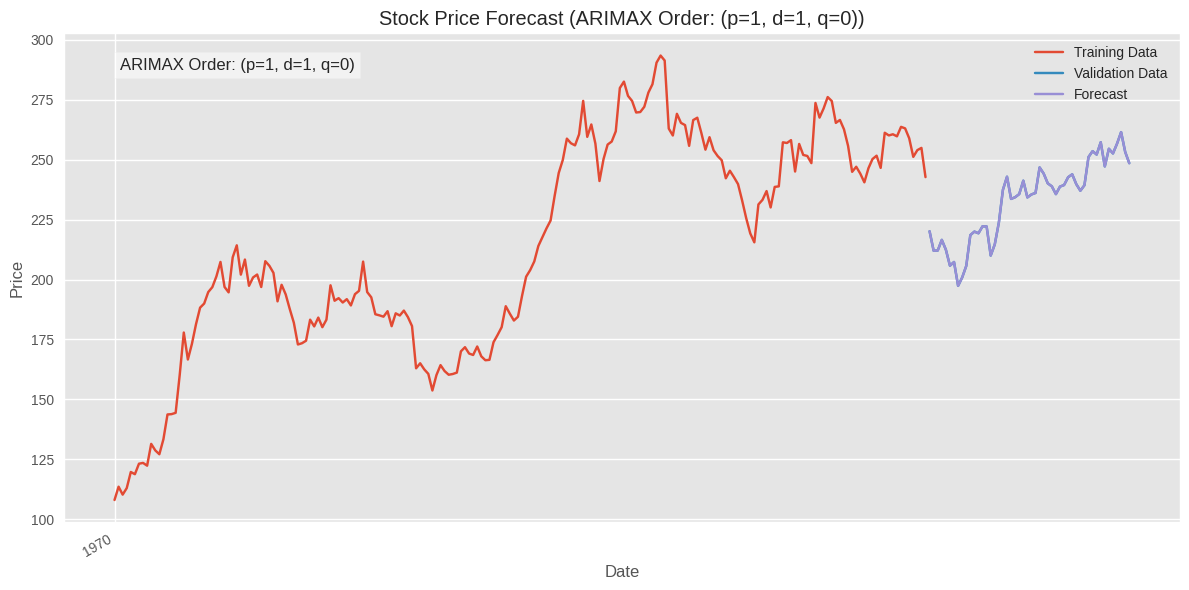

In [ ]:
arimax_model.plot_results()

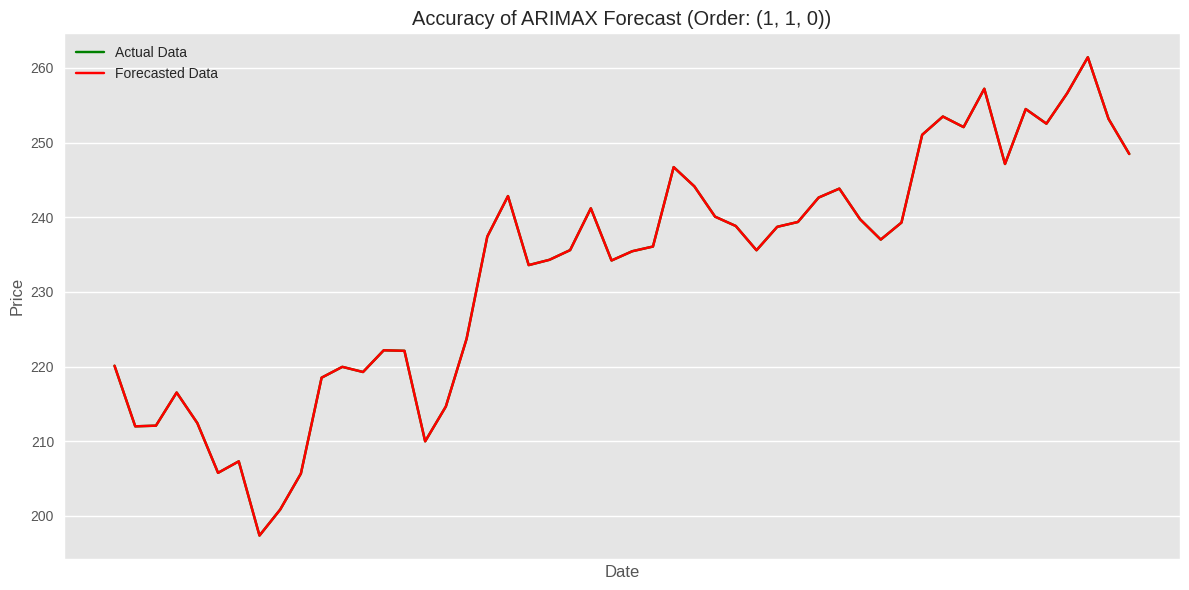

In [ ]:
arimax_model.plot_accuracy()

In [ ]:
# Print evaluation metrics and model summary
arimax_model.print_evaluation_metrics()

Final Mean Squared Error: 1.485064870396515e-19
Final Mean Absolute Error: 2.9813691071467475e-10
Final Root Mean Squared Error: 3.853653941905675e-10


In [ ]:
arimax_model.print_model_summary()

Model Coefficients:
Open: 0.0000
High: -0.0000
Low: -0.0000
Adj Close: 1.0000
Volume: 0.0000
ar.L1: -0.3629
sigma2: 0.0000


## 4.3 Autoregressive fractionally integrated moving average (AFRIMA)

In [ ]:
class AFRIMAModel:
    def __init__(self, train, test, train_exog, test_exog, target_column, exog_vars):
        """
        Initializes the AFRIMAModel with the given parameters.

        Parameters:
        train (pd.DataFrame): The training dataset containing the target variable and exogenous variables.
        test (pd.DataFrame): The testing dataset containing the target variable and exogenous variables.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        target_column (str): The name of the target variable in the train and test datasets.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train_exog[exog_vars]
        self.test_exog = test_exog[exog_vars]
        self.exog_vars = exog_vars

        # If necessary, convert the index to datetime
        if not isinstance(self.train.index, pd.DatetimeIndex):
            self.train.index = pd.to_datetime(self.train.index)
        if not isinstance(self.test.index, pd.DatetimeIndex):
            self.test.index = pd.to_datetime(self.test.index)

        self.best_order = None
        self.best_rmse = float("inf")
        self.best_model = None
        self.forecast = None
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    @staticmethod
    def mean_absolute_scaled_error(y_true, y_pred):
        """
        Calculates Mean Absolute Scaled Error (MASE).
        """
        n = len(y_true)
        d = np.abs(np.diff(y_true)).sum() / (n - 1)
        return np.abs(y_true - y_pred).mean() / d if d != 0 else float('inf')  # Avoid division by zero

    @staticmethod
    def symmetric_mean_absolute_percentage_error(y_true, y_pred):
        """
        Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
        """
        return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps))  # Avoid division by zero

    @staticmethod
    def adjusted_r_squared(r_squared, n, p):
        """
        Calculates Adjusted R-Squared.
        """
        return 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

    def evaluate_model(self, model, order):
        """
        Fits the model, makes forecasts, and evaluates performance metrics.
        """
        try:
            model_fit = model.fit(self.train, exogenous=self.train_exog)
            forecast = model_fit.predict_in_sample()
            mse = mean_squared_error(self.train, forecast)
            mae = mean_absolute_error(self.train, forecast)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((self.train - forecast) / self.train)) * 100 if not np.all(self.train == 0) else float('inf')  # Avoid division by zero
            smape = self.symmetric_mean_absolute_percentage_error(self.train, forecast)
            mase = self.mean_absolute_scaled_error(self.train, forecast)
            r_squared = r2_score(self.train, forecast)
            adj_r_squared = self.adjusted_r_squared(r_squared, len(self.train), len(order))
            aic_value = model_fit.aic()
            bic_value = model_fit.bic()

            return {
                'Order': order,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'SMAPE': smape,
                'MASE': mase,
                'R_Squared': r_squared,
                'Adj_R_Squared': adj_r_squared,
                'AIC': aic_value,
                'BIC': bic_value
            }
        except Exception as e:
            print(f"Error evaluating model with order (p={order[0]}, d={order[1]}, q={order[2]}): {e}")
            return None

    # def grid_search(self):
    #     """
    #     Performs a grid search to find the most optimal AFRIMA model order based on the lowest MSE.
    #     """
    #     p = q = range(0, 6)
    #     d_values = [0.5]  # Fractionally integrated
    #     pdq = list(itertools.product(p, d_values, q))
    #     results = []

    #     for param in pdq:
    #         try:
    #             p, d, q = param  # Unpack the current order
    #             model = auto_arima(self.train, exogenous=self.train_exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
    #             evaluation = self.evaluate_model(model, param)
    #             if evaluation:
    #                 mse = evaluation['MSE']
    #                 print(f'AFRIMA(p={p}, d={d}, q={q}) MSE: {mse:.4f}')

    #                 results.append(evaluation)
    #                 if mse < self.best_rmse:
    #                     self.best_rmse = mse
    #                     self.best_order = param
    #                     self.best_model = model
    #         except Exception as e:
    #             print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")

    #     if results:
    #         self.results_df = pd.DataFrame(results)
    #         print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
    #     else:
    #         print("No optimal order found.")

    def grid_search(self):
        """
        Performs a grid search to find the most optimal AFRIMA model order based on the lowest MSE.
        """
        p = q = range(0, 6)  # p and q ranges for AR and MA components (0 to 5)
        d_values = np.linspace(0, 1, 6)  # Fractional differencing values from 0 to 1 (6 evenly spaced values)

        pdq = list(itertools.product(p, d_values, q))
        results = []

        for param in pdq:
            try:
                p, d, q = param
                print(f'Testing AFRIMA order: (p={p}, d={d:.2f}, q={q})')
                model = auto_arima(self.train, exogenous=self.train_exog, order=(p, d, q), seasonal=False, suppress_warnings=True, with_intercept=False)
                evaluation = self.evaluate_model(model, param)
                if evaluation:
                    mse = evaluation['MSE']
                    print(f'AFRIMA(p={p}, d={d:.2f}, q={q}) MSE: {mse:.4f}')

                    results.append(evaluation)
                    if mse < self.best_rmse:
                        self.best_rmse = mse
                        self.best_order = param
                        self.best_model = model
            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d:.2f}, q={q}): {e}")

        if results:
            self.results_df = pd.DataFrame(results)
            print(f"Best order found: {self.best_order} with MSE: {self.best_rmse:.4f}")
        else:
            print("No optimal order found.")


    def fit_best_model(self):
        """
        Fits the best AFRIMA model found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        self.best_model = auto_arima(self.train, exogenous=self.train_exog, order=self.best_order, seasonal=False, suppress_warnings=True, with_intercept=False)
        self.best_model = self.best_model.fit(self.train, exogenous=self.train_exog)

    def make_forecast(self):
        """
        Makes forecast using the best fitted AFRIMA model.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")
        self.forecast = self.best_model.predict(n_periods=len(self.test), exogenous=self.test_exog)

    def plot_results(self):
        """
        Plots the training data, validation data, and forecasted values, and indicates the AFRIMA (p, d, q) values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")

        p, d, q = self.best_order  # Extract the p, d, q values

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train, label='Training Data')
        plt.plot(self.test.index, self.test, label='Validation Data')
        plt.plot(self.test.index, self.forecast, label='Forecast')
        plt.legend()

        # Title with AFRIMA order
        plt.title(f'Stock Price Forecast (AFRIMA Order: (p={p}, d={d}, q={q}))')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly

        # Add text to indicate the p, d, q values on the plot
        plt.text(0.05, 0.95, f'AFRIMA Order: (p={p}, d={d}, q={q})', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the accuracy of the forecast by comparing predicted vs actual values.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test, label='Actual Data', color='green')
        plt.plot(self.test.index, self.forecast, label='Forecasted Data', color='red')
        plt.fill_between(self.test.index, self.test, self.forecast, color='grey', alpha=0.2)
        plt.legend()
        plt.title(f'Accuracy of AFRIMA Forecast (Order: {self.best_order})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.gcf().autofmt_xdate()  # Ensure the dates on the x-axis are formatted correctly
        plt.tight_layout()
        plt.show()

    def print_evaluation_metrics(self):
        """
        Prints the evaluation metrics for the forecast.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        mse = mean_squared_error(self.test, self.forecast)
        mae = mean_absolute_error(self.test, self.forecast)
        rmse = np.sqrt(mse)
        print(f"Final Mean Squared Error: {mse}")
        print(f"Final Mean Absolute Error: {mae}")
        print(f"Final Root Mean Squared Error: {rmse}")

    def print_model_summary(self):
        """
        Prints the model summary and the parameters used.
        If 'SARIMAX' is found in the model summary, it is replaced with 'AFRIMA'.
        """
        if self.best_model is None:
            raise ValueError("Best model not fitted. Please run fit_best_model first.")

        # Get the original summary
        original_summary = self.best_model.summary().as_text()

        # Replace 'SARIMAX' with 'AFRIMA' in the summary
        modified_summary = original_summary.replace("SARIMAX", "AFRIMA")

        # Print the modified summary
        print(modified_summary)

        # Extract and print coefficients
        print("\nModel Coefficients:")
        for param_name, value in zip(self.best_model.arima_res_.params.index, self.best_model.arima_res_.params):
            print(f"{param_name}: {value:.4f}")


    def display_top_orders(self, top_n=5):
        """
        Displays the top N AFRIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search first.")

        # Sort by MSE and select top N rows
        top_results = self.results_df.sort_values(by='MSE').head(top_n)

        # Display the top results DataFrame
        print(f"Top {top_n} AFRIMA model orders with the lowest MSE:")
        display(top_results)

        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

In [ ]:

# exog_vars = ['Volume', 'Open', 'High', 'Low']

# # Exogenous variables
train_exog = train[exog_vars]
test_exog = test[exog_vars]

# Initialize the AFRIMAModel
afrima_model = AFRIMAModel(train, test, train_exog, test_exog, target_column, exog_vars)

Testing AFRIMA order: (p=0, d=0.00, q=0)
AFRIMA(p=0, d=0.00, q=0) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.00, q=1)
AFRIMA(p=0, d=0.00, q=1) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.00, q=2)
AFRIMA(p=0, d=0.00, q=2) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.00, q=3)
AFRIMA(p=0, d=0.00, q=3) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.00, q=4)
AFRIMA(p=0, d=0.00, q=4) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.00, q=5)
AFRIMA(p=0, d=0.00, q=5) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.20, q=0)
AFRIMA(p=0, d=0.20, q=0) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.20, q=1)
AFRIMA(p=0, d=0.20, q=1) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.20, q=2)
AFRIMA(p=0, d=0.20, q=2) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.20, q=3)
AFRIMA(p=0, d=0.20, q=3) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.20, q=4)
AFRIMA(p=0, d=0.20, q=4) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.20, q=5)
AFRIMA(p=0, d=0.20, q=5) MSE: 109.2565
Testing AFRIMA order: (p=0, d=0.40, q=0)

In [ ]:
# Perform grid search
afrima_model.grid_search()

In [ ]:
# # Display the top 5 model orders
top_orders = afrima_model.display_top_orders()

Top 5 AFRIMA model orders with the lowest MSE:


,Order,MSE,MAE,RMSE,MAPE,SMAPE,MASE,R_Squared,Adj_R_Squared,AIC,BIC
0,"(0, 0.0, 0)",109.256457,5.9303,10.452581,3.066497,3.577939,1.094781,0.946565,0.945747,1349.497662,1352.790967
137,"(3, 0.8, 5)",109.256457,5.9303,10.452581,3.066497,3.577939,1.094781,0.946565,0.945747,1349.497662,1352.790967
138,"(3, 1.0, 0)",109.256457,5.9303,10.452581,3.066497,3.577939,1.094781,0.946565,0.945747,1349.497662,1352.790967
139,"(3, 1.0, 1)",109.256457,5.9303,10.452581,3.066497,3.577939,1.094781,0.946565,0.945747,1349.497662,1352.790967
140,"(3, 1.0, 2)",109.256457,5.9303,10.452581,3.066497,3.577939,1.094781,0.946565,0.945747,1349.497662,1352.790967


In [ ]:
afrima_model.print_model_summary()

                               AFRIMA Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               AFRIMA(0, 1, 0)   Log Likelihood                -673.749
Date:                Wed, 14 Aug 2024   AIC                           1349.498
Time:                        07:28:51   BIC                           1352.791
Sample:                    01-01-1970   HQIC                          1350.831
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        51.0838      3.910     13.066      0.000      43.421      58.746
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                18.23
Prob(Q):                              0.55   Prob

In [ ]:
# # Fit the best model
afrima_model.fit_best_model()

In [ ]:
# Make forecast and plot results
afrima_model.make_forecast()

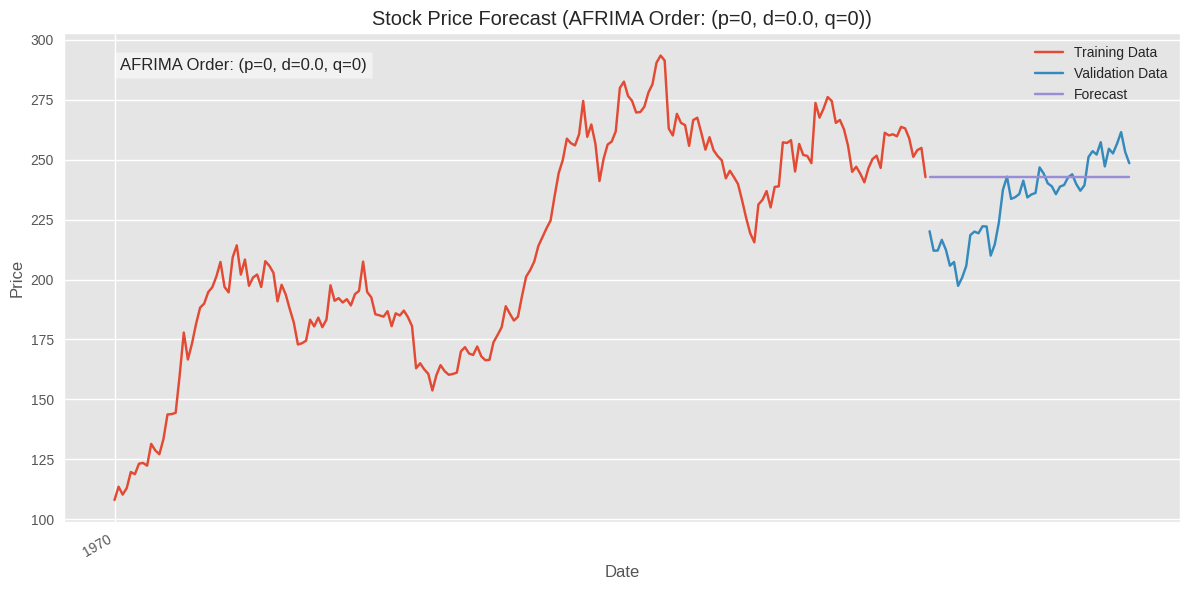

In [ ]:
afrima_model.plot_results()

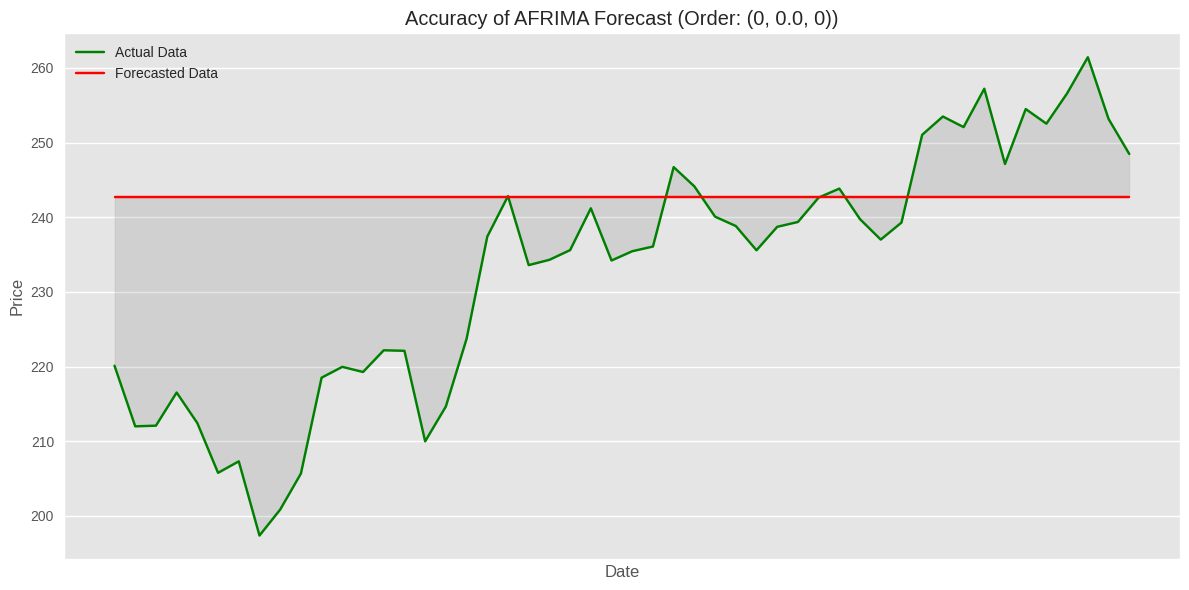

In [ ]:
afrima_model.plot_accuracy()

In [ ]:
afrima_model.print_evaluation_metrics()

Final Mean Squared Error: 369.7784286485054
Final Mean Absolute Error: 14.787396240234376
Final Root Mean Squared Error: 19.229623726129052


## 4.4 AutoRegressive Integrated Moving Average - Generalized Autoregressive Conditional Heteroskedasticity(ARIMA-GARCH)

Combining ARIMA and GARCH: To use ARIMA and GARCH together, you typically need to first fit an ARIMA model and then model the residuals of the ARIMA model with a GARCH model. Here’s a rough outline of the steps:

Fit an ARIMA model to your time series data.
Extract the residuals from the ARIMA model.
Fit a GARCH model to these residuals to model the volatility.

In [ ]:
class ARIMAGARCHModel:
    def __init__(self, train, test, train_exog, test_exog, target_column, exog_vars):
        """
        Initializes the ARIMAGARCHModel with the given parameters.

        Parameters:
        train (pd.DataFrame): The training dataset containing the target variable and exogenous variables.
        test (pd.DataFrame): The testing dataset containing the target variable and exogenous variables.
        train_exog (pd.DataFrame): The training exogenous variables.
        test_exog (pd.DataFrame): The testing exogenous variables.
        target_column (str): The name of the target variable in the train and test datasets.
        exog_vars (list): List of exogenous variables to include in the model.
        """
        self.train = pd.to_numeric(train[target_column], errors='coerce').dropna()
        self.test = pd.to_numeric(test[target_column], errors='coerce').dropna()
        self.train_exog = train_exog[exog_vars]
        self.test_exog = test_exog[exog_vars]
        self.exog_vars = exog_vars

        self.model_order = (0, 1, 0)
        self.garch_order = (1, 1)
        self.best_model = None
        self.best_garch_model = None
        self.forecast = None
        self.predictions = []
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

    def grid_search_arima_order(self):
        """
        Performs a grid search to find the best ARIMA model order based on the lowest MSE.
        """
        p = q = range(0, 6)  # p and q ranges for AR and MA components
        d = range(0, 3)  # d range for differencing

        pdq = list(itertools.product(p, d, q))
        self.results_df = pd.DataFrame(columns=[
            'Order', 'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared', 'AIC', 'BIC'
        ])

        for param in pdq:
            try:
                p, d, q = param
                print(f'Testing ARIMA order: (p={p}, d={d}, q={q})')
                model = ARIMA(self.train, exog=self.train_exog, order=(p, d, q))
                model_fit = model.fit()
                mse = mean_squared_error(self.train, model_fit.fittedvalues)
                mae = mean_absolute_error(self.train, model_fit.fittedvalues)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((self.train - model_fit.fittedvalues) / self.train)) * 100
                smape = np.mean(2 * np.abs(self.train - model_fit.fittedvalues) / (np.abs(self.train) + np.abs(model_fit.fittedvalues))) * 100
                mase = mae / np.mean(np.abs(self.train[1:] - self.train[:-1]))
                r_squared = r2_score(self.train, model_fit.fittedvalues)
                adj_r_squared = 1 - (1 - r_squared) * (len(self.train) - 1) / (len(self.train) - len(model_fit.params) - 1)
                aic = model_fit.aic
                bic = model_fit.bic

                # Append results to the DataFrame
                self.results_df = self.results_df.append({
                    'Order': (p, d, q),
                    'MSE': mse,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape,
                    'SMAPE': smape,
                    'MASE': mase,
                    'R_Squared': r_squared,
                    'Adj_R_Squared': adj_r_squared,
                    'AIC': aic,
                    'BIC': bic
                }, ignore_index=True)

                print(f'ARIMA(p={p}, d={d}, q={q}) MSE: {mse:.4f}')

            except Exception as e:
                print(f"Error evaluating model with order (p={p}, d={d}, q={q}): {e}")
                continue

        if not self.results_df.empty:
            # Sort the results by MSE and select the best model
            self.results_df.sort_values(by='MSE', inplace=True)
            best_row = self.results_df.iloc[0]
            self.model_order = best_row['Order']
            self.best_model = ARIMA(self.train, exog=self.train_exog, order=self.model_order).fit()

            print(f"Best ARIMA order found: {self.model_order} with MSE: {best_row['MSE']:.4f}")
        else:
            print("No optimal order found.")


    def fit_arima_garch(self):
        """
        Fits the ARIMA-GARCH model using the best ARIMA order found during grid search.
        """
        if self.best_model is None:
            raise ValueError("No ARIMA model fitted. Please run grid_search_arima_order first.")

        resid = self.best_model.resid
        garch_model = arch_model(resid, vol='Garch', p=self.garch_order[0], q=self.garch_order[1])
        self.best_garch_model = garch_model.fit(disp="off")

    def make_forecast(self):
        """
        Makes a forecast using the fitted ARIMA and GARCH models.
        """
        if self.best_model is None or self.best_garch_model is None:
            raise ValueError("Models not fitted. Please run fit_arima_garch first.")

        self.predictions = []
        self.history = [x for x in self.train]
        self.history_exog = self.train_exog.values.tolist()

        for i in range(len(self.test)):
            exog = self.test_exog.iloc[i:i+1]
            arima_forecast = self.best_model.get_forecast(steps=1, exog=exog).predicted_mean.iloc[0]
            resid = self.best_model.resid.iloc[-1]
            garch_forecast = self.best_garch_model.forecast(horizon=1).mean.iloc[-1, 0]

            yhat = arima_forecast + garch_forecast
            self.predictions.append(yhat)
            obs = self.test.iloc[i]
            self.history.append(obs)
            self.history_exog.append(exog.values[0])

    def evaluate_model(self):
        """
        Evaluates the performance of the ARIMA-GARCH model.
        """
        if not self.predictions:
            raise ValueError("No predictions made. Please run make_forecast first.")

        y_true = self.test
        y_pred = self.predictions

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
        mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))
        r_squared = r2_score(y_true, y_pred)
        adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - len(self.best_model.params) - 1)
        aic = self.best_model.aic
        bic = self.best_model.bic

        metrics = {
            'Model': 'ARIMA-GARCH',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared,
            'AIC': aic,
            'BIC': bic
        }

        return metrics

    def plot_results(self):
        """
        Plots the training data, test data, and forecasted values.
        """
        if not self.predictions:
            raise ValueError("No predictions made. Please run make_forecast first.")

        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train.values, label='Training Data')
        plt.plot(self.test.index, self.test.values, label='Testing Data', color='orange')
        plt.plot(self.test.index, self.predictions, label='Forecast (ARIMA-GARCH)', color='green')
        plt.title('ARIMA-GARCH Forecast')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def display_top_orders(self, top_n=5):
        """
        Displays the top N ARIMA model orders with the lowest MSE along with their evaluation metrics.

        Parameters:
        top_n (int): The number of top models to display.
        """
        if self.results_df.empty:
            raise ValueError("No results available. Please run grid_search_arima_order first.")

        top_results = self.results_df.sort_values(by='MSE').head(top_n)
        print(f"Top {top_n} ARIMA model orders with the lowest MSE:")
        print(top_results)
        return top_results

    def get_best_order(self):
        """
        Returns the best order found during grid search.
        """
        if self.best_order is None:
            raise ValueError("Best order not found. Please run grid_search first.")
        return self.best_order

    def get_forecast(self):
        """
        Returns the forecast made by the best fitted ARIMA model.
        """
        if self.forecast is None:
            raise ValueError("Forecast not made. Please run make_forecast first.")
        return self.forecast

In [ ]:
# Define the target variable and exogenous variables
exog_vars = ['Volume', 'Open', 'High', 'Low']

In [ ]:
# Exogenous variables
train_exog = train[exog_vars]
test_exog = test[exog_vars]

# Initialize the ARIMAGARCHModel
arima_garch_model = ARIMAGARCHModel(train, test, train_exog, test_exog, target_column, exog_vars)

In [ ]:
# Perform grid search to find the optimal ARIMA order
arima_garch_model.grid_search_arima_order()

Testing ARIMA order: (p=0, d=0, q=0)
Error evaluating model with order (p=0, d=0, q=0): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=0, q=1)
Error evaluating model with order (p=0, d=0, q=1): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=0, q=2)
Error evaluating model with order (p=0, d=0, q=2): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=0, q=3)
Error evaluating model with order (p=0, d=0, q=3): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=0, q=4)
Error evaluating model with order (p=0, d=0, q=4): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=0, q=5)
Error evaluating model with order (p=0, d=0, q=5): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=1, q=0)
Error evaluating model with order (p=0, d=1, q=0): 'DataFrame' object has no attribute 'append'
Testing ARIMA order: (p=0, d=1, q=1)
Error evaluating model with orde

In [ ]:
# Fit the ARIMA-GARCH model
arima_garch_model.fit_arima_garch()

ValueError: No ARIMA model fitted. Please run grid_search_arima_order first.

In [ ]:
# Make forecast and plot results
arima_garch_model.make_forecast()
arima_garch_model.plot_results()

ValueError: Models not fitted. Please run fit_arima_garch first.

In [ ]:
# Evaluate the model
metrics = arima_garch_model.evaluate_model()
metrics

ValueError: No predictions made. Please run make_forecast first.

In [ ]:
# Display the top 5 ARIMA model orders
top_orders = arima_garch_model.display_top_orders()

# 6. Long Short-Term Memory (LSTM)

## 6.1 Simple -LSTM

In [ ]:
# def lstm(stock_name, data):
#     # Choose only Close price of stock
#     data = data.filter(['Close'])
#     dataset = data.values
#     # Train data - 80%, test - 20%
#     training_data_len = int(np.ceil( len(dataset) * .80 ))

#     # Scale our data from 0 to 1
#     scaler = MinMaxScaler(feature_range=(0,1))
#     scaled_data = scaler.fit_transform(dataset)

#     # Use our scaled data for training
#     train_data = scaled_data[0:int(training_data_len), :]
#     x_train = []
#     y_train = []

#     for i in range(60, len(train_data)):
#         x_train.append(train_data[i-60:i, 0])
#         y_train.append(train_data[i, 0])
#         if i<= 61:
#             print(x_train)
#             print(y_train)
#             print()

#     x_train, y_train = np.array(x_train), np.array(y_train)

#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#     # Build LSTM model
#     model = Sequential()
#     model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
#     model.add(Dropout(0.35))
#     model.add(LSTM(64, return_sequences=False))
#     model.add(Dropout(0.3))
#     model.add(Dense(25, activation = 'relu'))
#     model.add(Dense(1))

#     # Compile the model
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#     # Тrain the model
#     model.fit(x_train, y_train, batch_size=1, epochs=2)

#     # Structure of the model
#     keras.utils.plot_model(model, 'simple_lstm.png', show_shapes=True)
#     keras.utils.plot_model(model, show_shapes=True)

#     # Create test dataset
#     test_data = scaled_data[training_data_len - 60: , :]
#     x_test = []
#     y_test = dataset[training_data_len:, :]
#     for i in range(60, len(test_data)):
#         x_test.append(test_data[i-60:i, 0])

#     x_test = np.array(x_test)

#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#     # Predict on test data
#     predictions = model.predict(x_test)
#     predictions = scaler.inverse_transform(predictions)

#     # For finding error we use RMSE formula, but MSE can be used too
#     rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
#     print(f'RMSE LSTM: {rmse}')

#     # Graphs
#     train = data[:training_data_len]
#     valid = data[training_data_len:]
#     train_gr = train['Close'].values
#     valid_gr = valid['Close'].values

#     preds_gr = np.reshape(predictions, (50,))

#     x_train = list(range(0, len(train_data)))
#     x_valid = list(range(len(train_data)-1, len(dataset)))
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=x_train, y=train_gr, mode='lines+markers', marker=dict(size=4),  name='train', marker_color='#39304A'))
#     fig.add_trace(go.Scatter(x=x_valid, y=valid_gr, mode='lines+markers', marker=dict(size=4), name='valid', marker_color='#A98D75'))
#     fig.add_trace(go.Scatter(x=x_valid, y=preds_gr, mode='lines+markers', marker=dict(size=4), name='predictions', marker_color='#FFAA00'))
#     fig.update_layout(legend_orientation="h",
#                   legend=dict(x=.5, xanchor="center"),
#                   plot_bgcolor='#FFFFFF',
#                   xaxis=dict(gridcolor = 'lightgrey'),
#                   yaxis=dict(gridcolor = 'lightgrey'),
#                   title_text = f'{stock_name} LSTM data', title_x = 0.5,
#                   xaxis_title="Timestep",
#                   yaxis_title="Stock price",
#                   margin=dict(l=0, r=0, t=30, b=0))
#     fig.show()

#     # Predict stock prices for next moth
#     data_new = yf.download(stock_name, start="2021-03-01", end="2021-04-30")

#     data_new = data_new.filter(['Close'])
#     dataset = data_new.values
#     training_data_len = len(dataset)

#     scaler = MinMaxScaler(feature_range=(0,1))
#     scaled_data = scaler.fit_transform(dataset)

#     test_data = scaled_data[training_data_len - len(data_new): , :]
#     x_test = []
#     y_test = dataset[training_data_len:, :]
#     for i in range(20, len(test_data)):
#         x_test.append(test_data[i-20:i, 0])

#     x_test = np.array(x_test)

#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#     hist_data_new = yf.download(stock_name, start="2021-04-01", end="2021-05-04")
#     hist_data_new = hist_data_new.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
#     hist_data_new = hist_data_new['Close']
#     hist_data_new = np.array(hist_data_new)
#     pred_lstm = model.predict(x_test)
#     pred_lstm = pred_lstm[:-1]
#     pred_lstm = scaler.inverse_transform(pred_lstm)


#     # build graphs
#     preds_gr = np.reshape(pred_lstm, (22,))
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=list(range(0, 21)), y=hist_data_new, mode='lines+markers',  name='historical', marker_color='#39304A'))
#     fig.add_trace(go.Scatter(x=list(range(0, 21)), y=preds_gr, mode='lines+markers', name='predictions', marker_color='#FFAA00'))
#     fig.update_layout(legend_orientation="h",
#                   legend=dict(x=.5, xanchor="center"),
#                   plot_bgcolor='#FFFFFF',
#                   xaxis=dict(gridcolor = 'lightgrey'),
#                   yaxis=dict(gridcolor = 'lightgrey'),
#                   title_text = f'{stock_name} LSTM prediction', title_x = 0.5,
#                   xaxis_title="Timestep",
#                   yaxis_title="Stock price",
#                   margin=dict(l=0, r=0, t=30, b=0))
#     fig.show()

#     return pred_lstm, rmse

In [ ]:
# # getting data from Yahoo Finance
# stock_name = 'TSLA'  # here you can change the name of stock ticker, for example we will take AMD ticker
# df_data = yf.download(stock_name, start="2020-03-26", end="2021-03-29")

In [ ]:
# lstm_pred, lstm_rmse = lstm(stock_name, df_data)

In [ ]:
class LSTMModel:
    def __init__(self, train, test, target_column):
        """
        Initializes the LSTMModel with training and testing datasets.

        Parameters:
        train (pd.DataFrame): The training dataset.
        test (pd.DataFrame): The testing dataset.
        target_column (str): The name of the column to use for LSTM modeling.
        """
        if target_column not in train.columns or target_column not in test.columns:
            raise ValueError(f"Column '{target_column}' not found in the dataframes.")

        self.target_column = target_column

        # Scale the data
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.train = self.scaler.fit_transform(train[[target_column]].values)
        self.test = self.scaler.transform(test[[target_column]].values)

        self.train_len = len(self.train)
        self.test_len = len(self.test)

        self.train_dates = train.index
        self.test_dates = test.index

        self.model = None
        self.predictions = None
        self.rmse = None
        self.results_df = pd.DataFrame(columns=[
            'MSE', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE',
            'R_Squared', 'Adj_R_Squared'
        ])

    def prepare_data(self, data, time_step=60):
        x, y = [], []
        for i in range(time_step, len(data)):
            x.append(data[i-time_step:i, 0])
            y.append(data[i, 0])
        return np.array(x), np.array(y)

    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.35))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model

    def fit(self, epochs=2, batch_size=1):
        x_train, y_train = self.prepare_data(self.train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        self.model = self.build_model((x_train.shape[1], 1))
        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

    def predict(self):
        x_test, y_test = self.prepare_data(np.concatenate((self.train[-60:], self.test)))

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        self.predictions = self.model.predict(x_test)
        self.predictions = self.scaler.inverse_transform(self.predictions)

        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))
        self.rmse = np.sqrt(np.mean((self.predictions - y_test) ** 2))

        return self.predictions, y_test, self.rmse

    def plot_results(self, train, test):
        train_values = train[self.target_column].values
        test_values = test[self.target_column].values

        pred_dates = test.index

        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train_values, label='Train', color='#39304A', linestyle='-')
        plt.plot(pred_dates, test_values, label='Valid', color='#A98D75', linestyle='-')
        plt.plot(pred_dates, self.predictions.reshape(-1), label='Predictions', color='#FFAA00', linestyle='-')

        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.title('LSTM Model Results')
        plt.legend()
        plt.xticks(rotation=45)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.gcf().autofmt_xdate()  # Beautify the x-labels

        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def evaluate_model(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
        mase = mae / np.mean(np.abs(y_true[1:] - y_true[:-1]))
        r_squared = r2_score(y_true, y_pred)
        adj_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - 1 - 1)

        evaluation_results = pd.DataFrame([{
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'SMAPE': smape,
            'MASE': mase,
            'R_Squared': r_squared,
            'Adj_R_Squared': adj_r_squared
        }])

        self.results_df = pd.concat([self.results_df, evaluation_results], ignore_index=True)
        return evaluation_results

In [ ]:
lstm_model = LSTMModel(train, test, target_column)

# Train the model
lstm_model.fit(epochs=2, batch_size=1)

# Make predictions
predictions, y_test, rmse = lstm_model.predict()
print(f'RMSE: {rmse}')

# Plot the results
lstm_model.plot_results(train, test)

# Evaluate the model and store the results in a DataFrame
evaluation_results = lstm_model.evaluate_model(y_test, predictions)
evaluation_results

# Display the DataFrame containing the results
lstm_model.results_df

# Comparison

In [ ]:
def compare_forecasts_and_plot(train, test, models):
    """
    Compares the forecasts from ARIMA, ARIMAX, AFRIMA, and ARIMAGARCH models and plots the results.

    Parameters:
    - train (pd.Series): The training data (for plotting context).
    - test (pd.Series): The actual test data (for comparison).
    - models (dict): A dictionary containing model instances with keys as model names.

    Example:
    models = {
        'ARIMA': arima_model_instance,
        'ARIMAX': arimax_model_instance,
        'AFRIMA': afrima_model_instance,
        'ARIMA-GARCH': arima_garch_model_instance
    }
    """
    plt.figure(figsize=(14, 8))

    # Plot the training data
    plt.plot(train.index, train.values, label='Training Data', color='blue', linestyle='--')

    # Plot the actual test data
    plt.plot(test.index, test.values, label='Actual Data', color='black')

    # Plot forecasts from each model
    for model_name, model_instance in models.items():
        order = model_instance.get_best_order()
        forecast = model_instance.get_forecast()
        plt.plot(test.index, forecast, label=f'{model_name} Forecast (Order: {order})')

    # Add titles and labels
    plt.title('Comparison of Forecasts from Different Models')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


In [ ]:
def compare_forecasts_and_plot(arima_model, arimax_model, afrima_model, arima_garch_model, lstm_model, train, test):
    """
    Compare forecasts from ARIMA, ARIMAX, AFRIMA, ARIMA-GARCH, and LSTM models, and plot the results.

    Parameters:
    arima_model (ArimaModel): Trained ARIMA model object.
    arimax_model (ARIMAXModel): Trained ARIMAX model object.
    afrima_model (AFRIMAModel): Trained AFRIMA model object.
    arima_garch_model (ARIMAGARCHModel): Trained ARIMA-GARCH model object.
    lstm_model (LSTMModel): Trained LSTM model object.
    train (pd.DataFrame): Training dataset with a DateTime index.
    test (pd.DataFrame): Testing dataset with a DateTime index.
    """

    # Generate forecasts using each model
    arima_model.make_forecast()
    arimax_model.make_forecast()
    afrima_model.make_forecast()
    arima_garch_model.make_forecast()
    lstm_forecast, _, _ = lstm_model.predict()

    # Access the forecasts
    arima_forecast = arima_model.forecast
    arimax_forecast = arimax_model.forecast
    afrima_forecast = afrima_model.forecast
    arima_garch_forecast = arima_garch_model.forecast

    # Extract the date index for the test set
    dates = test.index

    # Plot the forecasts along with the actual test data
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(train.index, train[arima_model.target_column], label='Training Data', color='blue')

    # Plot actual test data
    plt.plot(dates, test[arima_model.target_column], label='Actual Data', color='black')

    # Plot ARIMA forecast
    plt.plot(dates, arima_forecast, label=f'ARIMA Forecast (Order: {arima_model.get_best_order()})', color='green')

    # Plot ARIMAX forecast
    plt.plot(dates, arimax_forecast, label=f'ARIMAX Forecast (Order: {arimax_model.get_best_order()})', color='orange')

    # Plot AFRIMA forecast
    plt.plot(dates, afrima_forecast, label=f'AFRIMA Forecast (Order: {afrima_model.get_best_order()})', color='red')

    # Plot ARIMA-GARCH forecast
    plt.plot(dates, arima_garch_forecast, label=f'ARIMA-GARCH Forecast (Order: {arima_garch_model.get_best_order()})', color='purple')

    # Plot LSTM forecast
    plt.plot(dates, lstm_forecast, label='LSTM Forecast', color='magenta')

    # Add title and labels
    plt.title('Model Comparison: ARIMA, ARIMAX, AFRIMA, ARIMA-GARCH, and LSTM Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.gcf().autofmt_xdate()  # Beautify the x-labels
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
# Example usage:
compare_forecasts_and_plot(arima_model, arimax_model, afrima_model, arima_garch_model, lstm_model, train, test)